In [7]:
import os
import math
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.path import Path

from numpy import cos, pi
from scipy.spatial import ConvexHull
# from pykrige.ok import OrdinaryKriging

from dataclasses import dataclass # New

In [ ]:
# Your functions will be in a different file
# not in notebooks: HN

sys.path.append("/home/h.noorazar/dandeh/")
import dandeh_core as dc

# HN. Directories are repeated many times
Put all of them right here. Only once.
e.g. ```os.path.join(outputs_dir, "Daily_Chill_Portions.csv")``` is defined 3 times

In [7]:
# =========================
# CONFIG
# =========================
base_path = r"E:\OneDrive\Attachments\ReplicatePaper\Try-8\Try-8-GridMetData-Wenatchee"

# Folder for figures
pictures_dir = os.path.join(base_path, "Pictures")

# Folder for ALL generated outputs (CSVs)
outputs_dir = os.path.join(base_path, "Outputs")

# Create folders if they do not exist
os.makedirs(pictures_dir, exist_ok=True)
os.makedirs(outputs_dir, exist_ok=True)

# HN: Save figures in PDF

PDF is light. You can also save them as SVG, jpg, whatever. I am not sure if any journal accepts jpg!

Just in case of Google Doc or Microsoft office

PDF is light, high quality, usable in LaTex.

In [8]:
font_dict = {
    "title": {"fontsize": 10, "fontweight": "bold", "fontfamily": "Arial" },
    "x_label": {"fontsize": 22, "fontweight": "bold", "fontfamily": "Arial" },
    "y_label": {"fontsize": 22, "fontweight": "bold", "fontfamily": "Arial" },
    "tick_labels": { "labelsize": 22, "fontfamily": "Arial" },
    "legend": { "fontsize": 28, "title_fontsize": 28, "fontfamily": "Arial" },
    "annotation": { "fontsize": 28, "fontfamily": "Arial" },
    "bar_label": { "fontsize": 28, "fontfamily": "Arial" }
}

# HN. Put all fixed variables right here. Once:

e.g. This is repeated many times:

```python 
month_starts = [1, 31, 62, 93, 123, 154,
                184, 215, 243, 274, 304, 335]
```

# HN: Suggestion

Be consistent with column names. all lower case with underline between them. whatever you like, but be consistent, makes your life easier.

Right now it is all over the place: 
```python
    "DATE",
    "DOY",
    "BloomYear",
    "CP_daily",
    "GDH_daily",
    "CP_15d",
    "GDH_15d"
```

Traditionally, it is either underline between words or first letter of each word (starting from second word I think) is capital. So, either ```bloom_year``` or ```bloomYear```. 


You can add units to the column name so if in a meeting somebody asks, you do not have to
go back and check

In [54]:
# ============================================================
# CONFIG: Inputs / Outputs / Site / Model parameters
# ============================================================

# -------------------------
# Site / location settings
# -------------------------
#** Read from file. no hard coding. HN
station_name = "Rock Springs, PA"
lat = 40.7167
lon = -77.9333

# -------------------------
# Selection settings
# -------------------------
location = station_name      # use your CONFIG (e.g., "Wenatchee")
species  = "apple"
cultivar = "McIntosh"
stage    = "full_bloom"

# -------------------------
# Dynamic Chill Model constants- Empirical constants (as in Zhang 2011, Luedeling 2009)
# -------------------------
#** Save on disk. Read it from txt file
#** or pickle. HN
slp = 1.6          # slope
tetmlt = 277.0     # "melting" temperature (K)
a0 = 139500.0
a1 = 2.567e18
e0 = 4153.5
e1 = 12888.8

# -------------------------
# GDH (Anderson 1986) parameters
# -------------------------
#** Read from file. no hard coding. HN
#** You can also define object to contain all of these.
#** 
# class GDH_params(object):
#     def __init__(self):
#         self.Tb = 4.0
#         self.Tu = 25.0
#         self.Tc = 36.0
#         self.F = 1.0

Tb = 4.0
Tu = 25.0
Tc = 36.0
F  = 1.0

# ============================================================
# User-defined seasonal windows (Jul 1 → Jun 30, day 1-365) (Standard)
# User-defined seasonal windows (Jun 1 → May 30, day 1-365) (Extend)
# ============================================================
#** Read from file. no hard coding. HN
#** You can also define object to contain all of these.
#** All can be passed using class or a dictionary.

# example window for Wenatche-RedDel
# chill_start_day = 149     
# chill_end_day   = 245
# heat_start_day  = 227
# heat_end_day    = 320

# example window for Geneva-RedDel- For bloom year start from July 01
# chill_start_day = 128      
# chill_end_day   = 257
# heat_start_day  = 248
# heat_end_day    = 333

# # example window for Geneva-RedDel- For bloom year start from Jun 01
# chill_start_day = 158  #(Nov 05)      
# chill_end_day   = 287  #(March 14)
# heat_start_day  = 278    #(March 05)
# heat_end_day    = 363   #(May 29)

# # example window for Geneva-Empire- For bloom year start from Jun 01
# chill_start_day = 111  #(Sep 19)      
# chill_end_day   = 275  #(Mar 2)
# heat_start_day  = 283  #(Mar 10)
# heat_end_day    = 343  #(May 9)

# # # example window for Geneva-McIntosh- For bloom year start from Jun 01
# chill_start_day = 146  #(Oct 24)      
# chill_end_day   = 275  #(Mar 2)
# heat_start_day  = 279  #(Mar 6)      
# heat_end_day    = 348  #(May 14)

# # # example window for Wenatchee, WA- For bloom year start from Jun 01
# chill_start_day = 182  #(Nov 29)      
# chill_end_day   = 275  #(Mar 2)
# heat_start_day  = 253  #(Feb 11)      
# heat_end_day    = 352  #(May 18)

# # # example window for The Dallas,OR-pear-Bartlett For bloom year start from Jun 01
# chill_start_day = 143  #(Oct 21)      
# chill_end_day   = 252  #(Feb 10)
# heat_start_day  = 235  #(Jan 21)      
# heat_end_day    = 344  #(May 10)

# # example window for The Dallas,OR-pear-Anjou For bloom year start from Jun 01
# chill_start_day = 143 #(Oct 21)      
# chill_end_day   = 271 #(Feb 29)
# heat_start_day  = 233 #(Jan 19)      
# heat_end_day    = 354 #(May 20)

# # example window for RockSprings,PA-apple-Gala For bloom year start from Jun 01
# chill_start_day = 116 #(Sep 24)      
# chill_end_day   = 280 #(Mar 7)
# heat_start_day  = 236 #(Jan 22)      
# heat_end_day    = 337 #(May 3)

# # example window for RockSprings,PA-apple-Enterprise For bloom year start from Jun 01
# chill_start_day = 117 #(Sep 25)      
# chill_end_day   = 282 #(Mar 9)
# heat_start_day  = 274 #(Mar 1)      
# heat_end_day    = 337 #(May 3)

# # example window for RockSprings,PA-apple-Empire For bloom year start from Jun 01
# chill_start_day = 115 #(Sep 23)      
# chill_end_day   = 280 #(Mar 7)
# heat_start_day  = 238 #(Jan 24)      
# heat_end_day    = 337 #(May 3)

# example window for RockSprings,PA-apple-McIntosh For bloom year start from Jun 01
chill_start_day = 115 #(Sep 23)      
chill_end_day   = 280 #(Mar 7)
heat_start_day  = 274 #(Mar 1)      
heat_end_day    = 337 #(May 3)

# -------------------------
# Smoothing & BloomYear
# -------------------------
smooth_window = 15          # 15-day window
bloomyear_start_month = 6   # June

# -------------------------
# PLS parameters
# -------------------------
n_components = 2
vip_th = 0.8

In [10]:
##
##   Talk to chatGPT and pick your favorite way
##   of dealing with this.
##   You can write them as dictionary of dictionaries
##   if you want to write it as JSON file, you need to do it
##   Differently. JASON does not handle Tuples.
##   I like Pickle,  but later, if you wanna use it in R.
##   Pickle can be a problem
##   HN
##
##
# 1: Define a Data Structure
@dataclass(frozen=True)
class ThermalWindow:
    chill_start: int
    chill_end: int
    heat_start: int
    heat_end: int
    bloom_year_start: str  # "Jun 01", "Jul 01", etc.

# 2 Organize by Key Tuple
windows = {
    ("Wenatchee, WA", "apple", "RedDel", "Jun 01"): \
                      ThermalWindow(182, 275, 253, 352, "Jun 01"),
    ("Geneva", "apple", "RedDel", "Jul 01"): ThermalWindow(128, 257, 248, 333, "Jul 01"),
    ("Geneva", "apple", "RedDel", "Jun 01"): ThermalWindow(158, 287, 278, 363, "Jun 01"),
    ("Geneva", "apple", "Empire", "Jun 01"): ThermalWindow(111, 275, 283, 343, "Jun 01"),
    ("RockSprings, PA", "apple", "McIntosh", "Jun 01"): \
                ThermalWindow(115, 280, 274, 337, "Jun 01"),
}

# 3: Use
key = ("RockSprings, PA", "apple", "McIntosh", "Jun 01")
window = windows[key]

print(window.chill_start)

115


In [10]:
# ============================================================
# Block 1: Load Full Bloom from MASTER 
# ============================================================

# -------------------------
# Input / Output paths
# -------------------------
master_path = os.path.join(base_path, "apple_pear_phenology_master_dataset.xlsx")
out_path = os.path.join(outputs_dir, "selected_stage_doy.csv")

# -------------------------
# 1) Read master Excel file
# -------------------------
df_master = pd.read_excel(master_path, engine="openpyxl")

# -------------------------
# 2) Filter rows (exact match; locations are standardized)
# -------------------------
df_sel = df_master[
    (df_master["location_name"] == location) &
    (df_master["species"] == species) &
    (df_master["cultivar"] == cultivar) &
    (df_master["bloom_stage"] == stage)
].copy()

# Safety check
if df_sel.empty:
    raise ValueError("No bloom data found. Check location, species, cultivar, or stage.")

# -------------------------
# 3) Use master bloom_date as the single source of truth
# -------------------------
df_sel["Full_Bloom_Date"] = pd.to_datetime(df_sel["bloom_date"], errors="coerce")

# -------------------------
# 4) Create Month/Day from Full_Bloom_Date (for compatibility)
# -------------------------
df_sel["Month"] = df_sel["Full_Bloom_Date"].dt.month
df_sel["Day"]   = df_sel["Full_Bloom_Date"].dt.day

# -------------------------
# 5) Year and DOY (use master if available; otherwise compute safely)
# -------------------------
# Year: prefer master "year" if it exists; otherwise extract from date
if "year" in df_sel.columns and df_sel["year"].notna().any():
    df_sel["Year"] = pd.to_numeric(df_sel["year"], errors="coerce").astype("Int64")
else:
    df_sel["Year"] = df_sel["Full_Bloom_Date"].dt.year.astype("Int64")

# DOY: prefer master "doy" if it exists; otherwise compute from date
if "doy" in df_sel.columns and df_sel["doy"].notna().any():
    df_sel["DOY"] = pd.to_numeric(df_sel["doy"], errors="coerce")
else:
    df_sel["DOY"] = df_sel["Full_Bloom_Date"].dt.dayofyear

# -------------------------
# 6) Final tidy output (MATCHES your old block)
# -------------------------
tidy = (
    df_sel[["Year", "Month", "Day", "Full_Bloom_Date", "DOY"]]
    .dropna()
    .sort_values("Year")
    .reset_index(drop=True)
)

# -------------------------
# 7) Save with the SAME filename used before
# -------------------------
tidy.to_csv(out_path, index=False)
print("Saved:", out_path)
print(tidy.head(50))

Saved: E:\OneDrive\Attachments\ReplicatePaper\Try-8\Try-8-GridMetData-Wenatchee\Outputs\selected_stage_doy.csv
    Year  Month   Day Full_Bloom_Date    DOY
0   1997    5.0   8.0      1997-05-08  128.0
1   1998    4.0  24.0      1998-04-24  114.0
2   1999    5.0   8.0      1999-05-08  128.0
3   2000    5.0   2.0      2000-05-02  123.0
4   2001    5.0   6.0      2001-05-06  126.0
5   2002    5.0   1.0      2002-05-01  121.0
6   2003    5.0   4.0      2003-05-04  124.0
7   2004    5.0   1.0      2004-05-01  122.0
8   2005    5.0  11.0      2005-05-11  131.0
9   2006    5.0   4.0      2006-05-04  124.0
10  2007    5.0   8.0      2007-05-08  128.0
11  2008    5.0   5.0      2008-05-05  126.0
12  2009    5.0   4.0      2009-05-04  124.0
13  2010    4.0  20.0      2010-04-20  110.0
14  2011    5.0   7.0      2011-05-07  127.0
15  2012    4.0  16.0      2012-04-16  107.0
16  2013    5.0   7.0      2013-05-07  127.0
17  2014    5.0  12.0      2014-05-12  132.0
18  2015    5.0   8.0      2015-05

In [11]:
# # --------------------------------------------------------
# # Block 1: Combine Year + (Month/Day) and compute DOY
# # --------------------------------------------------------

# # Input and output paths
# # in_path  = r"E:\OneDrive - Washington State University (email.wsu.edu)\Attachments\ReplicatePaper\Try-4-GridMetData-Wenatchee\Red Delicious Apple Historical Full Bloom recorded in Wenatchee, WA.xlsx"
# # out_path = r"E:\OneDrive - Washington State University (email.wsu.edu)\Attachments\ReplicatePaper\Try-4-GridMetData-Wenatchee\Cleaned_Full_Bloom_With_DOY.csv"

# in_path  = os.path.join(base_path, "Red Delicious Apple Historical Full Bloom recorded in Wenatchee, WA.xlsx")
# out_path = os.path.join(base_path, "Cleaned_Full_Bloom_With_DOY.csv")


# # 1) Read only the first two columns
# df = pd.read_excel(in_path, usecols=[0, 1], engine="openpyxl")
# df.columns = ["Year", "MonthDay_raw"]

# # 2) Parse Month/Day (e.g., "Apr 28", "4/28", "April-28")
# monthday = pd.to_datetime(df["MonthDay_raw"].astype(str).str.strip(), errors="coerce")

# # Extract month and day
# df["Month"] = monthday.dt.month
# df["Day"]   = monthday.dt.day

# # 3) Ensure Year is numeric
# df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype("Int64")

# # 4) Build a proper date from Year + Month + Day
# def combine_date(row):
#     if pd.notna(row["Year"]) and pd.notna(row["Month"]) and pd.notna(row["Day"]):
#         return pd.Timestamp(int(row["Year"]), int(row["Month"]), int(row["Day"]))
#     return pd.NaT

# df["Full_Bloom_Date"] = df.apply(combine_date, axis=1)

# # 5) Compute DOY (day of year)
# df["DOY"] = df["Full_Bloom_Date"].dt.dayofyear

# # 6) Keep tidy columns and sort
# tidy = df[["Year", "Month", "Day", "Full_Bloom_Date", "DOY"]].sort_values(["Year"]).reset_index(drop=True)

# # 7) Save for the next steps
# tidy.to_csv(out_path, index=False)
# print("Saved:", out_path)
# print(tidy.head(15))

In [12]:
# print(tidy.to_string(index=True))

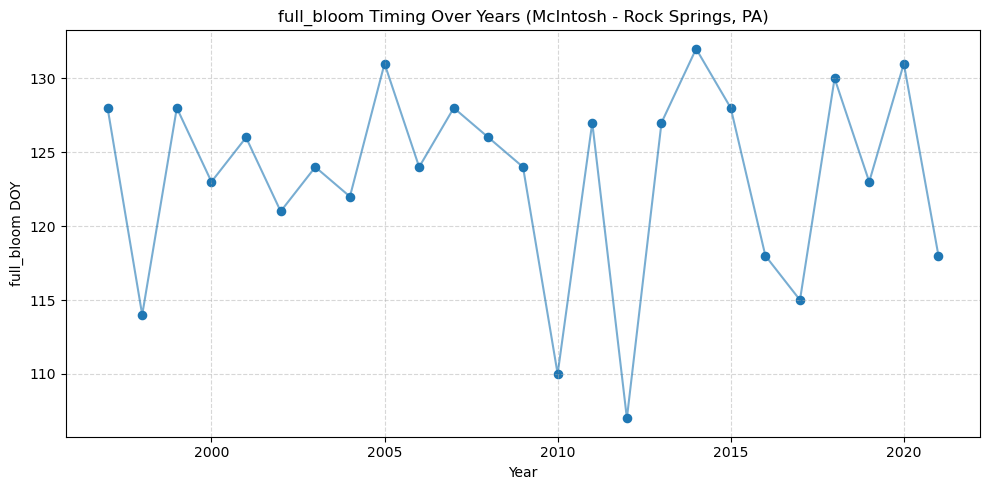

In [13]:
# --------------------------------------------------------
# BLOCK X: Plot DOY vs Year (Full Bloom Timing Trend)
# --------------------------------------------------------


# Extract columns
years = tidy["Year"]
doy   = tidy["DOY"]

# Create the plot
plt.figure(figsize=(10,5))

# Scatter points
plt.scatter(years, doy, s=35)

# Line to show trend visually
plt.plot(years, doy, alpha=0.6)

# Labels and title
plt.xlabel("Year")
plt.ylabel(f"{stage} DOY")
plt.title(f"{stage} Timing Over Years ({cultivar} - {location})")

# Optional: grid
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [14]:
# --------------------------------------------------------
# Block 2: Clean weather data and add geographic info (Wenatchee, WA)
# --------------------------------------------------------



# # === 1. File paths ===
# in_path  = r"E:\OneDrive - Washington State University (email.wsu.edu)\Attachments\ReplicatePaper\Try-4-GridMetData-Wenatchee\WeatherData-Wenatchee.csv"
# out_path = r"E:\OneDrive - Washington State University (email.wsu.edu)\Attachments\ReplicatePaper\Try-4-GridMetData-Wenatchee\WeatherData_Wenatchee_Cleaned.csv"

in_path  = os.path.join(base_path, "WaetherData-RockSprings,PA.csv")
out_path = os.path.join(outputs_dir, "WeatherData_Wenatchee_Cleaned.csv")

# === 2. Read the CSV file ===
df = pd.read_csv(in_path)

# === 3. Keep only relevant columns ===
df = df[["DATE", "TMAX", "TMIN"]].copy()

# === 4. Convert DATE column to datetime ===
df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")

# === 5. Add geographic information for Wenatchee, WA ===
df["STATION_NAME"] = station_name
df["LATITUDE_DEG"] = lat
df["LONGITUDE_DEG"] = lon

# === 6. Sort chronologically and reset index ===
df = df.sort_values(by="DATE").reset_index(drop=True)

# === 7. Interpolate missing TMAX and TMIN values ===
print("\n🔧 Interpolating missing TMAX/TMIN values...")
missing_before = df[["TMAX", "TMIN"]].isna().sum()
print("Missing before interpolation:\n", missing_before)

df["TMAX"] = df["TMAX"].interpolate(limit_direction="both")
df["TMIN"] = df["TMIN"].interpolate(limit_direction="both")

missing_after = df[["TMAX", "TMIN"]].isna().sum()
print("\n✅ Missing after interpolation:\n", missing_after)

# === 8. Check for any remaining empty cells and show in VS Code ===
print("\n🔍 Checking for remaining empty (NaN) cells in dataframe...")

if df.isna().any().any():
    print("⚠️ Found missing values!\n")

    # A detailed report in rows and columns
    for row_idx, row in df.iterrows():
        for col in df.columns:
            if pd.isna(row[col]):
                print(f"❌ Row {row_idx+1}, Column '{col}' is empty (DATE={row['DATE']})")
else:
    print("✅ No empty cells found. All data is complete.")

# === 9. Save cleaned dataset ===
df.to_csv(out_path, index=False)

# === 10. Show preview in VS Code terminal ===
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print("\n✅ Cleaned weather data saved successfully!")
print(f"📁 File location: {out_path}\n")
print("Preview of cleaned data:")
print(df.head(20))


🔧 Interpolating missing TMAX/TMIN values...
Missing before interpolation:
 TMAX    0
TMIN    0
dtype: int64

✅ Missing after interpolation:
 TMAX    0
TMIN    0
dtype: int64

🔍 Checking for remaining empty (NaN) cells in dataframe...
✅ No empty cells found. All data is complete.

✅ Cleaned weather data saved successfully!
📁 File location: E:\OneDrive\Attachments\ReplicatePaper\Try-8\Try-8-GridMetData-Wenatchee\Outputs\WeatherData_Wenatchee_Cleaned.csv

Preview of cleaned data:
         DATE  TMAX   TMIN      STATION_NAME  LATITUDE_DEG  LONGITUDE_DEG
0  1979-01-01  8.25   4.65  Rock Springs, PA       40.7167       -77.9333
1  1979-01-02  7.55  -7.15  Rock Springs, PA       40.7167       -77.9333
2  1979-01-03 -7.05 -15.75  Rock Springs, PA       40.7167       -77.9333
3  1979-01-04 -6.45 -12.95  Rock Springs, PA       40.7167       -77.9333
4  1979-01-05 -5.15 -11.25  Rock Springs, PA       40.7167       -77.9333
5  1979-01-06 -0.85  -6.85  Rock Springs, PA       40.7167       -77.9333

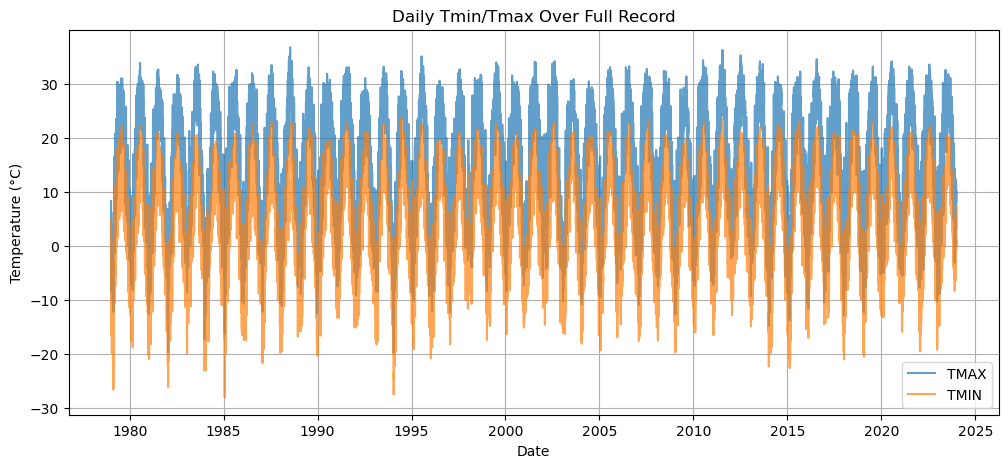

In [15]:
plt.figure(figsize=(12,5))
plt.plot(df["DATE"], df["TMAX"], label="TMAX", alpha=0.7)
plt.plot(df["DATE"], df["TMIN"], label="TMIN", alpha=0.7)
plt.legend()
plt.title("Daily Tmin/Tmax Over Full Record")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()

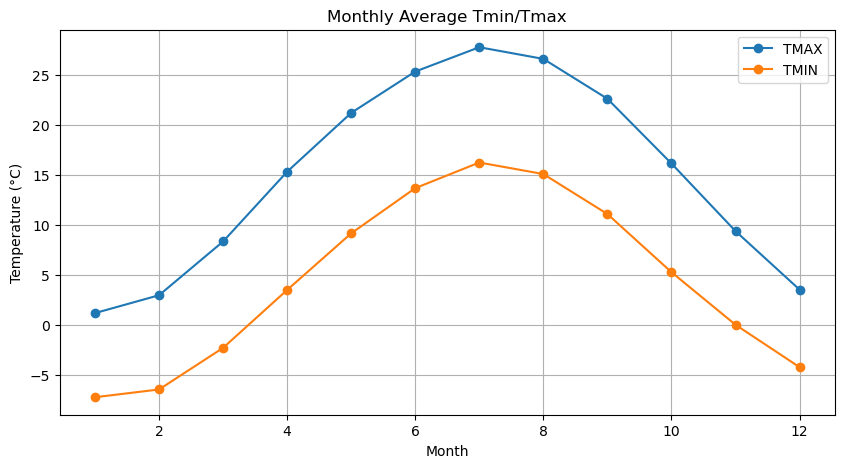

In [16]:
df["Month"] = df["DATE"].dt.month
monthly = df.groupby("Month")[["TMAX","TMIN"]].mean()

monthly.plot(kind="line", figsize=(10,5), marker="o")
# print(monthly)

plt.title("Monthly Average Tmin/Tmax")
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

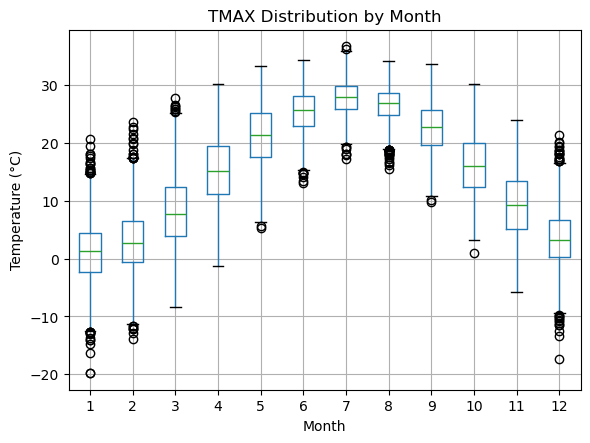

<Figure size 1200x600 with 0 Axes>

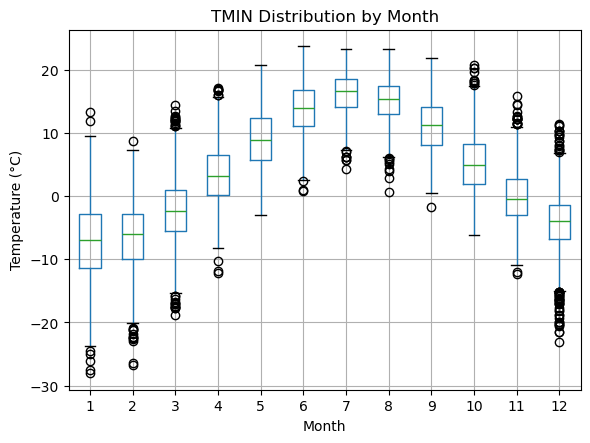

In [17]:
df["Month"] = df["DATE"].dt.month

plt.figure(figsize=(12,6))
df.boxplot(column="TMAX", by="Month")
plt.title("TMAX Distribution by Month")
plt.suptitle("")
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.show()

plt.figure(figsize=(12,6))
df.boxplot(column="TMIN", by="Month")
plt.title("TMIN Distribution by Month")
plt.suptitle("")
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.show()

In [18]:
# plt.figure(figsize=(6,6))
# plt.scatter(df["TMIN"], df["TMAX"], alpha=0.4)
# plt.xlabel("TMIN")
# plt.ylabel("TMAX")
# plt.title("TMAX vs TMIN")
# plt.grid(True)
# plt.show()

In [19]:
# --------------------------------------------------------
# Block 3: Estimate sunrise/sunset & compute hourly temperatures
# --------------------------------------------------------


# === 1. Load cleaned weather data ===
# in_path = r"E:\OneDrive - Washington State University (email.wsu.edu)\Attachments\ReplicatePaper\Try-4-GridMetData-Wenatchee\WeatherData_Wenatchee_Cleaned.csv"
# out_path = r"E:\OneDrive - Washington State University (email.wsu.edu)\Attachments\ReplicatePaper\Try-4-GridMetData-Wenatchee\WeatherData_Wenatchee_Hourly.csv"

# Why this is here? It is already defined earlier! HN
in_path  = os.path.join(outputs_dir, "WeatherData_Wenatchee_Cleaned.csv")
out_path = os.path.join(outputs_dir, "WeatherData_Wenatchee_Hourly.csv")


df = pd.read_csv(in_path)
df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")
df["DOY"] = df["DATE"].dt.dayofyear

# === 2. Define helper functions ===
# Take these functions out and put them in a different file HN


# === 3. Apply model to all days and hours ===

hours = np.arange(0, 24)  # hours 0–23

records = []

for i in range(len(df)):
    doy = int(df.loc[i, "DOY"])
    tmin = df.loc[i, "TMIN"]
    tmax = df.loc[i, "TMAX"]

    # neighbors (previous / next day)
    tmin_prev = df.loc[i-1, "TMIN"] if i > 0 else tmin
    tmax_prev = df.loc[i-1, "TMAX"] if i > 0 else tmax
    tmin_next = df.loc[i+1, "TMIN"] if i < len(df)-1 else tmin

    sunrise, sunset = dc.sunrise_sunset(doy, lat)
    sunrise_prev, sunset_prev = dc.sunrise_sunset(doy-1 if doy > 1 else 1, lat)
    sunrise_next, _ = dc.sunrise_sunset(doy+1 if doy < 365 else 365, lat)

    for hour in hours:
        temp = hourly_temp(hour, tmin, tmax, tmin_prev, tmax_prev,
                           tmin_next, sunrise, sunset, sunrise_prev,
                           sunset_prev, sunrise_next)
        records.append({
            "DATE": df.loc[i, "DATE"],
            "DOY": doy,
            "HOUR": hour,
            "TEMP_EST_C": temp,
            "SUNRISE": sunrise,
            "SUNSET": sunset
        })

# === 4. Build hourly dataframe ===
df_hourly = pd.DataFrame(records)

# === 5. Save results ===
df_hourly.to_csv(out_path, index=False)
print(f"\n✅ Hourly temperature file saved successfully: {out_path}")
print(df_hourly.head(24))


✅ Hourly temperature file saved successfully: E:\OneDrive\Attachments\ReplicatePaper\Try-8\Try-8-GridMetData-Wenatchee\Outputs\WeatherData_Wenatchee_Hourly.csv
         DATE  DOY  HOUR  TEMP_EST_C   SUNRISE     SUNSET
0  1979-01-01    1     0    5.318842  7.347517  16.652483
1  1979-01-01    1     1    5.198982  7.347517  16.652483
2  1979-01-01    1     2    5.091316  7.347517  16.652483
3  1979-01-01    1     3    4.993590  7.347517  16.652483
4  1979-01-01    1     4    4.904123  7.347517  16.652483
5  1979-01-01    1     5    4.821627  7.347517  16.652483
6  1979-01-01    1     6    4.745094  7.347517  16.652483
7  1979-01-01    1     7    4.673719  7.347517  16.652483
8  1979-01-01    1     8    5.202444  7.347517  16.652483
9  1979-01-01    1     9    6.019302  7.347517  16.652483
10 1979-01-01    1    10    6.760170  7.347517  16.652483
11 1979-01-01    1    11    7.383935  7.347517  16.652483
12 1979-01-01    1    12    7.855980  7.347517  16.652483
13 1979-01-01    1    13   

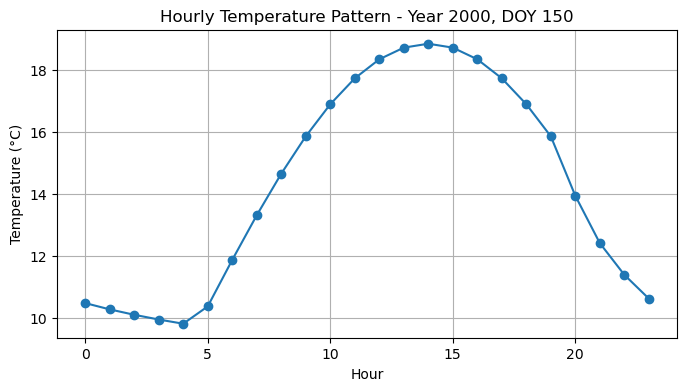

In [20]:
# Make sure Year column exists in the hourly dataset
df_hourly["Year"] = pd.to_datetime(df_hourly["DATE"]).dt.year

# Plot for a specific year + DOY
sample_year = 2000
sample_doy  = 150

df_sample = df_hourly[
    (df_hourly["Year"] == sample_year) &
    (df_hourly["DOY"] == sample_doy)
]

plt.figure(figsize=(8,4))
plt.plot(df_sample["HOUR"], df_sample["TEMP_EST_C"], marker="o")
plt.title(f"Hourly Temperature Pattern - Year {sample_year}, DOY {sample_doy}")
plt.xlabel("Hour")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()

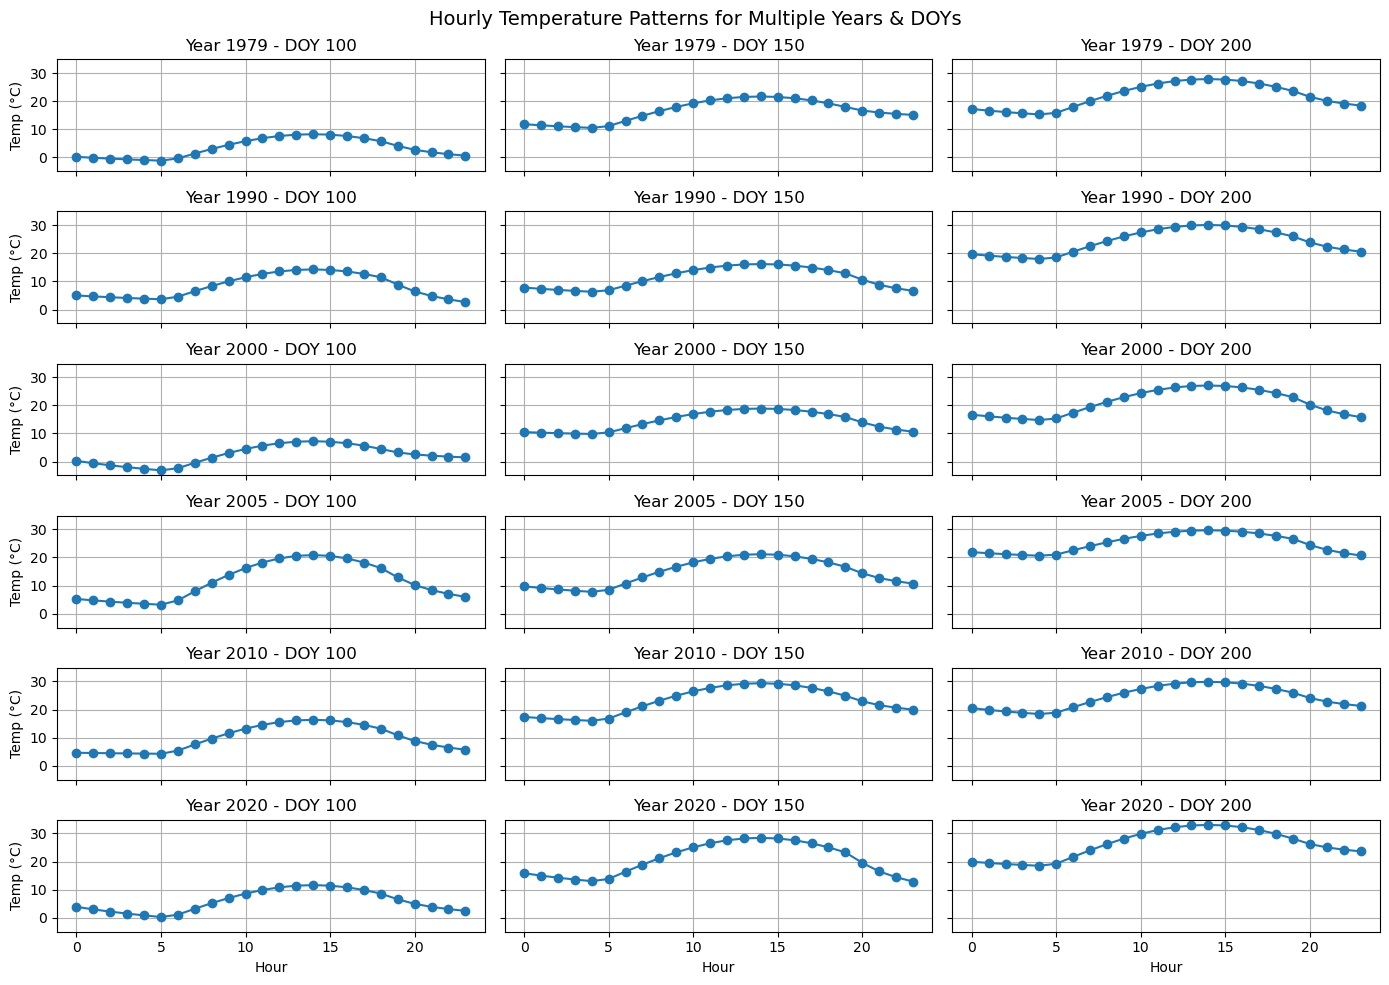

In [21]:
# --------------------------------------------
# Plot hourly temperature for multiple years & DOYs
# --------------------------------------------


# Load hourly dataset
df_hourly = pd.read_csv(os.path.join(outputs_dir, "WeatherData_Wenatchee_Hourly.csv"))
df_hourly["DATE"] = pd.to_datetime(df_hourly["DATE"])
df_hourly["Year"] = df_hourly["DATE"].dt.year

# Select which years and DOYs to plot
years = [1979, 1990, 2000, 2005, 2010, 2020]   # <-- choose your years
doys  = [100, 150, 200]            # <-- choose your DOYs

# Create subplots
fig, axes = plt.subplots(len(years), len(doys), figsize=(14, 10), sharex=True, sharey=True)

# Loop over each year and DOY
for i, yr in enumerate(years):
    for j, dy in enumerate(doys):

        # Filter data for this combination
        df_plot = df_hourly[(df_hourly["Year"] == yr) & (df_hourly["DOY"] == dy)]

        ax = axes[i, j]

        # Plot hourly curve
        ax.plot(df_plot["HOUR"], df_plot["TEMP_EST_C"], marker="o")

        # Title for each small panel
        ax.set_title(f"Year {yr} - DOY {dy}")

        # Labels only on edges
        if i == len(years) - 1:
            ax.set_xlabel("Hour")
        if j == 0:
            ax.set_ylabel("Temp (°C)")

        ax.grid(True)

plt.suptitle("Hourly Temperature Patterns for Multiple Years & DOYs", fontsize=14)
plt.tight_layout()
plt.show()

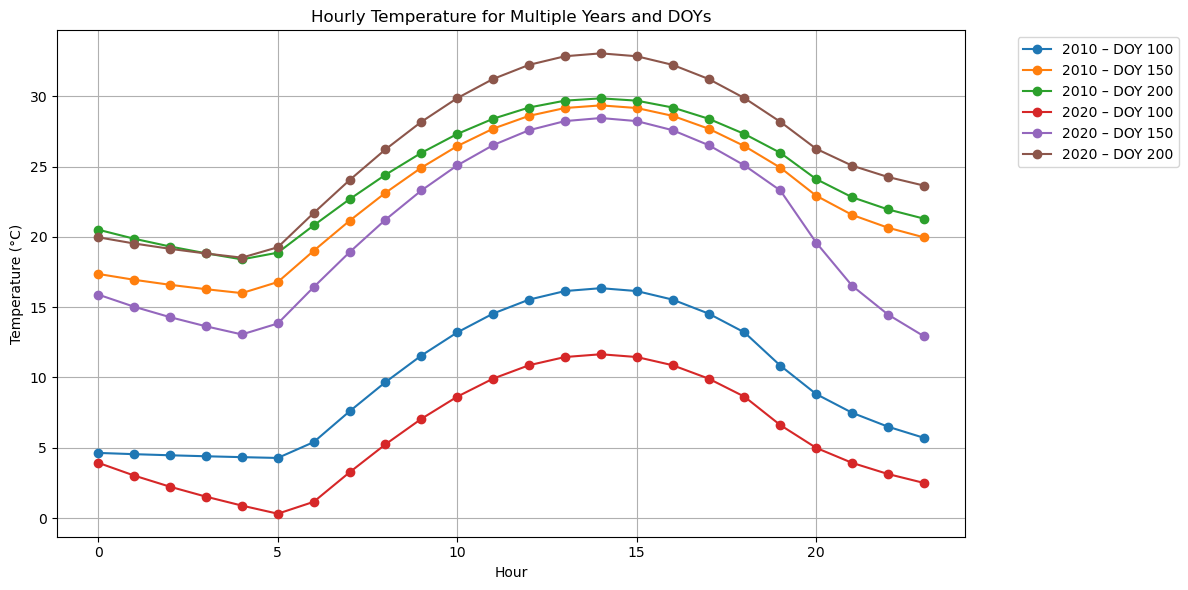

In [22]:
# ----------------------------------------------------
# Plot multiple years & DOYs on the same single figure
# ----------------------------------------------------

# Load hourly dataset
df_hourly = pd.read_csv(os.path.join(outputs_dir, "WeatherData_Wenatchee_Hourly.csv"))
df_hourly["DATE"] = pd.to_datetime(df_hourly["DATE"])
df_hourly["Year"] = df_hourly["DATE"].dt.year

# Choose years and DOYs to plot
# years = [1931, 1932, 1935, 1940]   
years = [1931, 1935, 1940, 2010, 2020]   # set your own years

doys  = [100, 150, 200]            # set your own DOYs

plt.figure(figsize=(12, 6))

# Loop over each (year, DOY) pair and plot them
for yr in years:
    for dy in doys:

        # Filter dataset
        df_plot = df_hourly[(df_hourly["Year"] == yr) & (df_hourly["DOY"] == dy)]

        # Skip if this combination doesn't exist
        if df_plot.empty:
            continue

        # Plot temperature curve
        plt.plot(
            df_plot["HOUR"], 
            df_plot["TEMP_EST_C"], 
            marker="o", 
            label=f"{yr} – DOY {dy}"
        )

# Labeling
plt.title("Hourly Temperature for Multiple Years and DOYs")
plt.xlabel("Hour")
plt.ylabel("Temperature (°C)")
plt.grid(True)

# Unique legend (avoid duplicates)
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

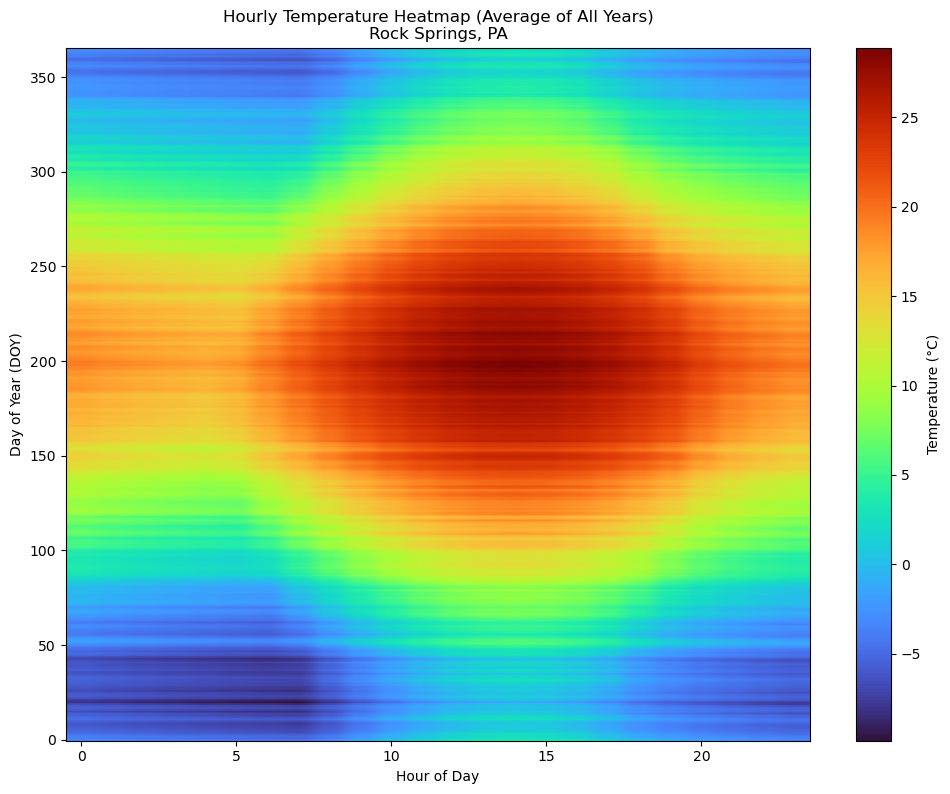

In [23]:
# Load hourly dataset
df_hourly = pd.read_csv(os.path.join(outputs_dir, "WeatherData_Wenatchee_Hourly.csv"))
df_hourly["DOY"] = df_hourly["DOY"].astype(int)

# --- 1) Pivot: average temperature for each (DOY, HOUR) over all years ---
heatmap_data = df_hourly.pivot_table(
    index="DOY", 
    columns="HOUR", 
    values="TEMP_EST_C",
    aggfunc="mean"
)

# --- 2) Plot as heatmap ---
plt.figure(figsize=(12, 9))
plt.imshow(heatmap_data, aspect="auto", cmap="turbo", origin="lower")

# --- 3) Labels ---
plt.colorbar(label="Temperature (°C)")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Year (DOY)")
plt.title(f"Hourly Temperature Heatmap (Average of All Years)\n{location}")

plt.show()

In [24]:
# --------------------------------------------------------
# STEP 5: Chill Portions per hour (Dynamic Model, Luedeling / Fishman)
# --------------------------------------------------------

# === 1) Paths ===
in_path  = os.path.join(outputs_dir, "WeatherData_Wenatchee_Hourly.csv")
out_path = os.path.join(outputs_dir, "WeatherData_Wenatchee_Hourly_ChillPortion.csv")


# === 3) Load hourly temperatures ===
df = pd.read_csv(in_path)
df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")
df = df.sort_values(["DATE", "HOUR"]).reset_index(drop=True)

# Kelvin conversion
df["T_K"] = df["TEMP_EST_C"] + 273.15

# Prepare output columns
df["CP_hourly"]     = 0.0
df["CP_cumulative"] = 0.0
df["interE"]        = 0.0
df["interS"]        = 0.0

# === 4) Initialize previous values ===
interE_prev = None
CP_prev     = 0.0

# === 5) Loop over all hours ===
for i, row in df.iterrows():
    TK = float(row["T_K"])

    # --- 5.1: temperature-dependent terms ---
    expo = slp * tetmlt * ((TK - tetmlt) / TK)
    exp_term = math.exp(expo)
    xi = exp_term / (1.0 + exp_term)   # logistic term

    xs = (a0 / a1) * math.exp(-(e0 - e1) / TK)
    

    ak1 = a1 * math.exp(-e1 / TK)

    # --- 5.2: interS (intermediate product in "stable" form) ---
    if i == 0:
        interS = 0.0
    else:
        if interE_prev < 1.0:
            interS = interE_prev
        else:
            interS = interE_prev * (1.0 - xi)

    # --- 5.3: interE (current intermediate state) ---
    interE = xs - (xs - interS) * math.exp(-ak1)

    # --- 5.4: hourly Chill Portion increment (delt) ---
    if i == 0:
        delt = 0.0
        CP_cum = 0.0
    else:
        if interE < 1.0:
            delt = 0.0
        else:
            delt = xi * interE
        CP_cum = CP_prev + delt

    # --- 5.5: save outputs for this hour ---
    df.at[i, "interE"]        = interE
    df.at[i, "interS"]        = interS
    df.at[i, "CP_hourly"]     = delt
    df.at[i, "CP_cumulative"] = CP_cum

    # --- 5.6: update for next iteration ---
    interE_prev = interE
    CP_prev     = CP_cum

# === 6) Save results ===
df.to_csv(out_path, index=False)

# === 7) Preview ===
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
print("✅ Chill Portions (Dynamic Model) computed successfully.")
print(f"Saved file: {out_path}\n")
print(df.head(36))

✅ Chill Portions (Dynamic Model) computed successfully.
Saved file: E:\OneDrive\Attachments\ReplicatePaper\Try-8\Try-8-GridMetData-Wenatchee\Outputs\WeatherData_Wenatchee_Hourly_ChillPortion.csv

         DATE  DOY  HOUR  TEMP_EST_C   SUNRISE     SUNSET         T_K  \
0  1979-01-01    1     0    5.318842  7.347517  16.652483  278.468842   
1  1979-01-01    1     1    5.198982  7.347517  16.652483  278.348982   
2  1979-01-01    1     2    5.091316  7.347517  16.652483  278.241316   
3  1979-01-01    1     3    4.993590  7.347517  16.652483  278.143590   
4  1979-01-01    1     4    4.904123  7.347517  16.652483  278.054123   
5  1979-01-01    1     5    4.821627  7.347517  16.652483  277.971627   
6  1979-01-01    1     6    4.745094  7.347517  16.652483  277.895094   
7  1979-01-01    1     7    4.673719  7.347517  16.652483  277.823719   
8  1979-01-01    1     8    5.202444  7.347517  16.652483  278.352444   
9  1979-01-01    1     9    6.019302  7.347517  16.652483  279.169302   
1

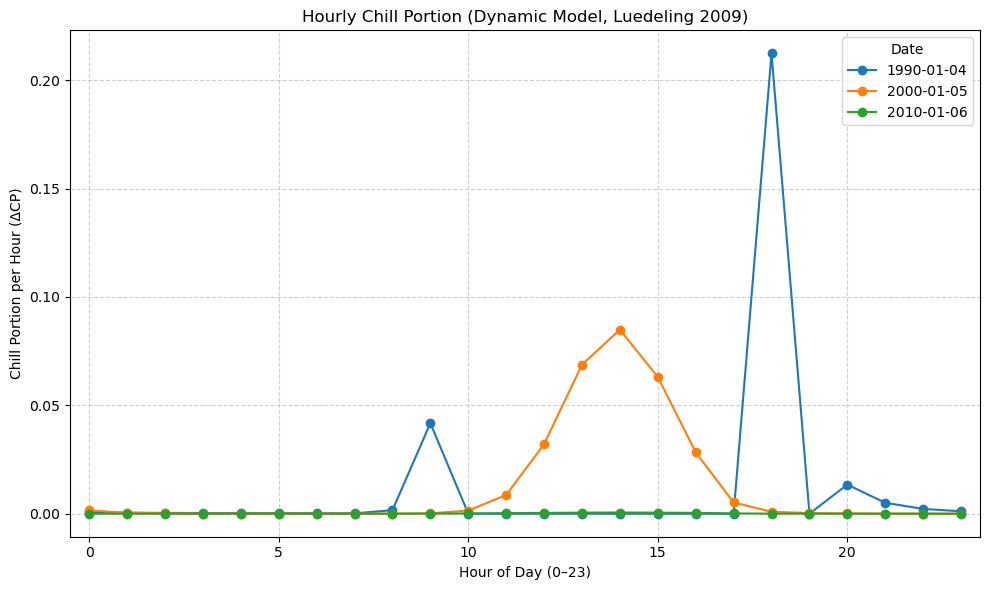

In [25]:
# --------------------------------------------------------
# Block 6: Visualize hourly Chill Portion variation by hour
# --------------------------------------------------------

# === 1. Load hourly chill data ===
in_path = os.path.join(outputs_dir, "WeatherData_Wenatchee_Hourly_ChillPortion.csv")
df = pd.read_csv(in_path)
df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")

# === 2. Select one or more days to visualize ===
# You can edit this list to check different dates
dates_to_plot = ["1990-01-04", "2000-01-05", "2010-01-06"]

# === 3. Plot CP_hourly vs. HOUR ===
plt.figure(figsize=(10, 6))

for d in dates_to_plot:
    sub = df[df["DATE"] == d]
    if sub.empty:
        print(f"⚠️ No data found for {d}")
        continue
    plt.plot(sub["HOUR"], sub["CP_hourly"], marker="o", label=f"{d}")

# === 4. Plot formatting ===
plt.title("Hourly Chill Portion (Dynamic Model, Luedeling 2009)")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Chill Portion per Hour (ΔCP)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Date")
plt.xlim(-0.5, 23.5)
plt.tight_layout()

plt.show()

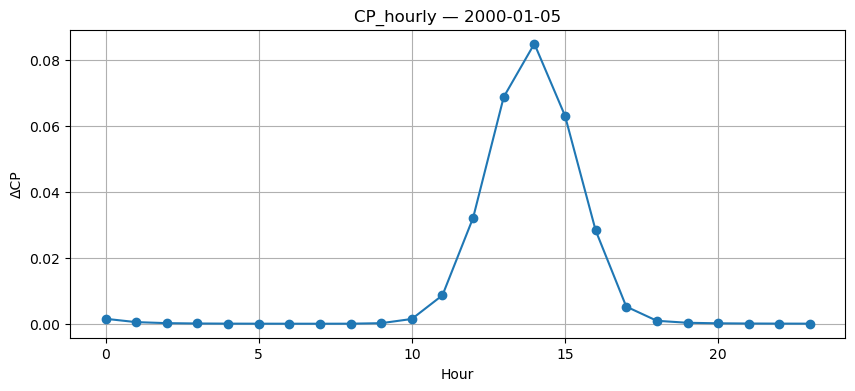

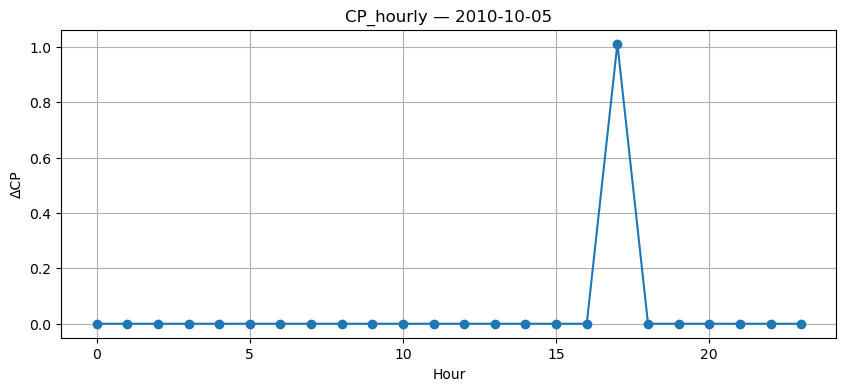

In [26]:
hourly_path = os.path.join(outputs_dir, "WeatherData_Wenatchee_Hourly_ChillPortion.csv")
df = pd.read_csv(hourly_path, parse_dates=["DATE"])

sample_dates = ["2000-01-05", "2010-10-05"]

for d in sample_dates:
    sub = df[df["DATE"] == d]
    plt.figure(figsize=(10,4))
    plt.plot(sub["HOUR"], sub["CP_hourly"], marker="o")
    plt.title(f"CP_hourly — {d}")
    plt.xlabel("Hour")
    plt.ylabel("ΔCP")
    plt.grid(True)
    plt.show()

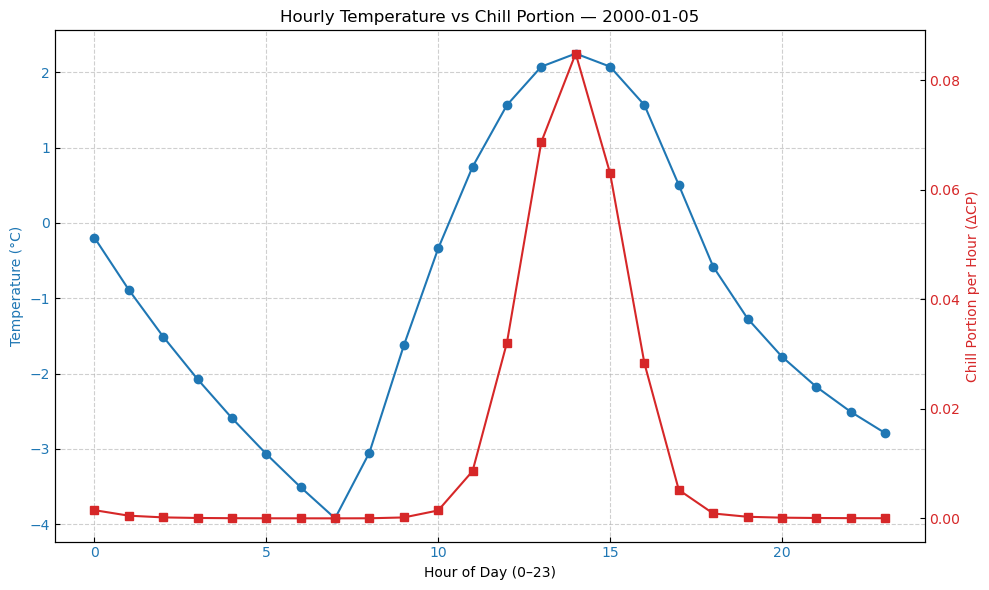

In [27]:
# --------------------------------------------------------
# Block 7: Plot temperature and hourly Chill Portion together
# --------------------------------------------------------

# === 1. Load hourly data ===
in_path = os.path.join(outputs_dir, "WeatherData_Wenatchee_Hourly_ChillPortion.csv")
df = pd.read_csv(in_path)
df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")

# === 2. Select a date to visualize ===
target_date = "2000-01-05"   # you can change this

sub = df[df["DATE"] == target_date]
if sub.empty:
    print(f"⚠️ No data found for {target_date}")
else:
    # === 3. Create dual-axis plot ===
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Left axis → temperature (°C)
    color = "tab:blue"
    ax1.set_xlabel("Hour of Day (0–23)")
    ax1.set_ylabel("Temperature (°C)", color=color)
    ax1.plot(sub["HOUR"], sub["TEMP_EST_C"], color=color, marker="o", label="Temperature (°C)")
    ax1.tick_params(axis="both", labelcolor=color, direction="in")
    ax1.grid(True, linestyle="--", alpha=0.6)

    # Right axis → Chill Portion (ΔCP/hour)
    ax2 = ax1.twinx()
    color = "tab:red"
    ax2.set_ylabel("Chill Portion per Hour (ΔCP)", color=color)
    ax2.plot(sub["HOUR"], sub["CP_hourly"], color=color, marker="s", label="ΔCP/hour")
    ax2.tick_params(axis="y", labelcolor=color, direction="in")

    # === 4. Formatting ===
    plt.title(f"Hourly Temperature vs Chill Portion — {target_date}")
    fig.tight_layout()
    plt.show()

In [28]:
# --------------------------------------------------------
# Block 8: Compute Daily Chill Portions from hourly outputs
# --------------------------------------------------------

# === 1) Load hourly chill portion file ===
in_path = os.path.join(outputs_dir, "WeatherData_Wenatchee_Hourly_ChillPortion.csv")
df = pd.read_csv(in_path)
df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")

# === 2) Group by DATE and sum CP_hourly ===
daily_chill = df.groupby("DATE", as_index=False).agg(
    CP_daily=("CP_hourly", "sum")
)

# === 3) Add DOY for easier plotting ===
daily_chill["DOY"] = daily_chill["DATE"].dt.dayofyear

# === 4) Save daily chill portion file ===
out_path = os.path.join(outputs_dir, "Daily_Chill_Portions.csv")
daily_chill.to_csv(out_path, index=False)

print("✅ Daily chill portions saved:", out_path)
print(daily_chill.head(20))

✅ Daily chill portions saved: E:\OneDrive\Attachments\ReplicatePaper\Try-8\Try-8-GridMetData-Wenatchee\Outputs\Daily_Chill_Portions.csv
         DATE      CP_daily  DOY
0  1979-01-01  0.000000e+00    1
1  1979-01-02  2.346063e-02    2
2  1979-01-03  3.951154e-08    3
3  1979-01-04  1.797938e-07    4
4  1979-01-05  2.585654e-06    5
5  1979-01-06  4.005963e-03    6
6  1979-01-07  6.324044e-01    7
7  1979-01-08  2.090664e-01    8
8  1979-01-09  8.504905e-09    9
9  1979-01-10  4.977980e-07   10
10 1979-01-11  1.467644e-08   11
11 1979-01-12  1.034180e-06   12
12 1979-01-13  5.967235e-01   13
13 1979-01-14  1.203982e+00   14
14 1979-01-15  6.446460e-08   15
15 1979-01-16  9.391187e-04   16
16 1979-01-17  2.534063e-01   17
17 1979-01-18  2.958788e-04   18
18 1979-01-19  9.545440e-09   19
19 1979-01-20  7.654248e-04   20


In [29]:
print( "Maximum Daily Chill Portion:",daily_chill["CP_daily"].max())

Maximum Daily Chill Portion: 3.515880797873645


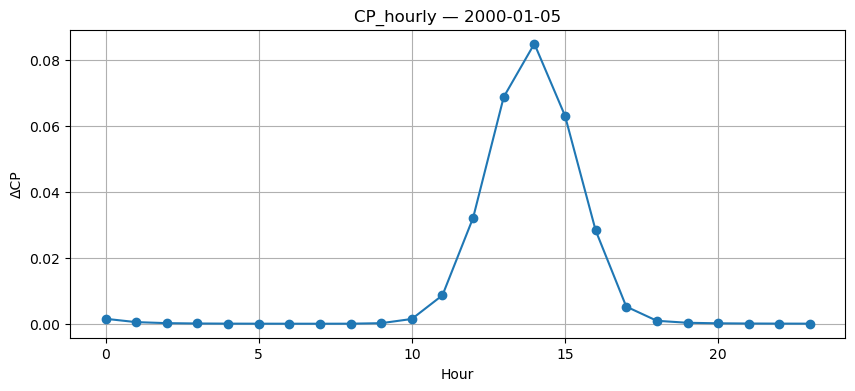

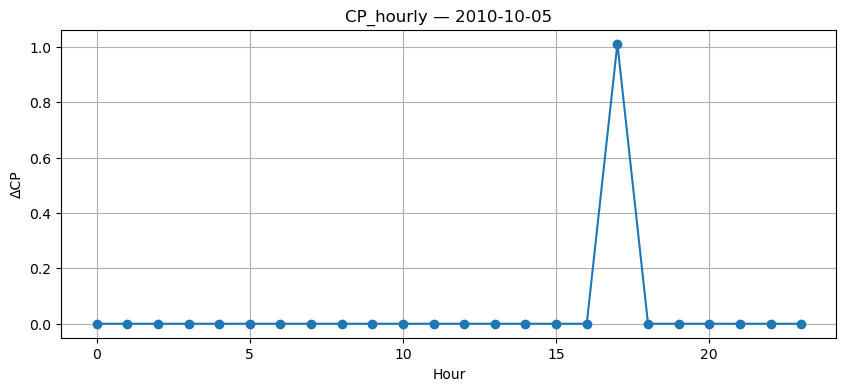

In [30]:
hourly_path = os.path.join(outputs_dir, "WeatherData_Wenatchee_Hourly_ChillPortion.csv")
df = pd.read_csv(hourly_path, parse_dates=["DATE"])

sample_dates = ["2000-01-05", "2010-10-05"]

for d in sample_dates:
    sub = df[df["DATE"] == d]
    plt.figure(figsize=(10,4))
    plt.plot(sub["HOUR"], sub["CP_hourly"], marker="o")
    plt.title(f"CP_hourly — {d}")
    plt.xlabel("Hour")
    plt.ylabel("ΔCP")
    plt.grid(True)
    plt.show()

In [31]:
# --------------------------------------------------------
# BLOCK 9: Compute Hourly and Daily Heat (GDH)
#           Using the Anderson (1986) Model
# --------------------------------------------------------

# === 1) File paths ===
in_path  = os.path.join(outputs_dir, "WeatherData_Wenatchee_Hourly.csv")
out_hourly_path = os.path.join(outputs_dir, "WeatherData_Wenatchee_Hourly_GDH.csv")
out_daily_path  = os.path.join(outputs_dir, "Daily_Heat_GDH.csv")

# === 2) Load hourly temperature data ===
df = pd.read_csv(in_path)
df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")

# === 3) Define GDH function (Anderson 1986) ===
# Moved to dandeh_core.py HN

# === 4) Compute hourly GDH ===
df["GDH_hourly"] = df["TEMP_EST_C"].apply(dc.gdh_anderson)

# === 5) Save hourly GDH file ===
df.to_csv(out_hourly_path, index=False)
print("\n✅ Hourly GDH file saved:", out_hourly_path)
print(df.head(24))


# === 6) Compute daily GDH ===
daily_gdh = df.groupby("DATE", as_index=False)["GDH_hourly"].sum()
daily_gdh = daily_gdh.rename(columns={"GDH_hourly": "GDH_daily"})

# Add DOY
daily_gdh["DOY"] = daily_gdh["DATE"].dt.dayofyear

# === 7) Save daily GDH ===
daily_gdh.to_csv(out_daily_path, index=False)

print("\n✅ Daily GDH file saved:", out_daily_path)
print(daily_gdh.head(20))


✅ Hourly GDH file saved: E:\OneDrive\Attachments\ReplicatePaper\Try-8\Try-8-GridMetData-Wenatchee\Outputs\WeatherData_Wenatchee_Hourly_GDH.csv
         DATE  DOY  HOUR  TEMP_EST_C   SUNRISE     SUNSET  GDH_hourly
0  1979-01-01    1     0    5.318842  7.347517  16.652483    0.203703
1  1979-01-01    1     1    5.198982  7.347517  16.652483    0.168454
2  1979-01-01    1     2    5.091316  7.347517  16.652483    0.139623
3  1979-01-01    1     3    4.993590  7.347517  16.652483    0.115780
4  1979-01-01    1     4    4.904123  7.347517  16.652483    0.095899
5  1979-01-01    1     5    4.821627  7.347517  16.652483    0.079218
6  1979-01-01    1     6    4.745094  7.347517  16.652483    0.065162
7  1979-01-01    1     7    4.673719  7.347517  16.652483    0.053286
8  1979-01-01    1     8    5.202444  7.347517  16.652483    0.169426
9  1979-01-01    1     9    6.019302  7.347517  16.652483    0.475464
10 1979-01-01    1    10    6.760170  7.347517  16.652483    0.882496
11 1979-01-01   

In [32]:
# --------------------------------------------------------
# BLOCK 10: Combine Daily Chill (CP) and Daily Heat (GDH)
# --------------------------------------------------------

# === 1) File paths ===
cp_path   = os.path.join(outputs_dir, "Daily_Chill_Portions.csv")
gdh_path  = os.path.join(outputs_dir, "Daily_Heat_GDH.csv")
out_path  = os.path.join(outputs_dir, "Daily_CP_GDH_Combined.csv")

# === 2) Load both daily files ===
df_cp  = pd.read_csv(cp_path)
df_gdh = pd.read_csv(gdh_path)

# Convert DATE to datetime in both datasets
df_cp["DATE"]  = pd.to_datetime(df_cp["DATE"], errors="coerce")
df_gdh["DATE"] = pd.to_datetime(df_gdh["DATE"], errors="coerce")

# === 3) Merge CP and GDH by DATE ===
df_combined = pd.merge(
    df_cp,
    df_gdh,
    on="DATE",
    how="inner"        # keep only dates present in both files
)

# === 4) Clean up duplicated DOY columns ===
# We keep DOY from df_cp (or df_gdh, both are identical)
if "DOY_x" in df_combined.columns and "DOY_y" in df_combined.columns:
    df_combined = df_combined.rename(columns={"DOY_x": "DOY"})
    df_combined = df_combined.drop(columns=["DOY_y"])

# === 5) Sort by date (important for next steps) ===
df_combined = df_combined.sort_values("DATE").reset_index(drop=True)

# === 6) Reorder columns to a clean and consistent order ===
desired_cols = ["DATE", "DOY", "CP_daily", "GDH_daily"]
df_combined = df_combined[desired_cols]

# === 7) Save combined dataset ===
df_combined.to_csv(out_path, index=False)

print("\n✅ Daily CP + GDH combined file saved:", out_path)
print(df_combined.head(20))


✅ Daily CP + GDH combined file saved: E:\OneDrive\Attachments\ReplicatePaper\Try-8\Try-8-GridMetData-Wenatchee\Outputs\Daily_CP_GDH_Combined.csv
         DATE  DOY      CP_daily  GDH_daily
0  1979-01-01    1  0.000000e+00  13.588063
1  1979-01-02    2  2.346063e-02   4.606526
2  1979-01-03    3  3.951154e-08   0.000000
3  1979-01-04    4  1.797938e-07   0.000000
4  1979-01-05    5  2.585654e-06   0.000000
5  1979-01-06    6  4.005963e-03   0.000000
6  1979-01-07    7  6.324044e-01   0.000000
7  1979-01-08    8  2.090664e-01   0.000000
8  1979-01-09    9  8.504905e-09   0.000000
9  1979-01-10   10  4.977980e-07   0.000000
10 1979-01-11   11  1.467644e-08   0.000000
11 1979-01-12   12  1.034180e-06   0.000000
12 1979-01-13   13  5.967235e-01   0.000000
13 1979-01-14   14  1.203982e+00   0.000000
14 1979-01-15   15  6.446460e-08   0.000000
15 1979-01-16   16  9.391187e-04   0.000000
16 1979-01-17   17  2.534063e-01   0.000000
17 1979-01-18   18  2.958788e-04   0.000000
18 1979-01-19   19

In [33]:
# --------------------------------------------------------
# BLOCK 11: Apply 15-day running mean (Moving Average) (CP_15d and GDH_15d)
# --------------------------------------------------------

# === 1) File paths ===
in_path  = os.path.join(outputs_dir, "Daily_CP_GDH_Combined.csv")
out_path = os.path.join(outputs_dir, "Daily_CP_GDH_15daySmooth.csv")

# === 2) Load combined daily dataset ===
df = pd.read_csv(in_path)
df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")

# === 3) Sort by date (important before rolling) ===
df = df.sort_values("DATE").reset_index(drop=True)

# === 4) Apply 15-day centered running mean ===
# CP: Chill Portions
df["CP_15d"] = df["CP_daily"].rolling(
    window=smooth_window,       # 15-day window
    center=True,     # centered around each day
    min_periods=1    # compute even at edges
).mean()

# GDH: Growing Degree Hours
df["GDH_15d"] = df["GDH_daily"].rolling(
    window=15,
    center=True,
    min_periods=1
).mean()

# === 5) Save smoothed dataset ===
df.to_csv(out_path, index=False)

print("\n✅ 15-day smoothed dataset saved:", out_path)
print(df.head(30))


✅ 15-day smoothed dataset saved: E:\OneDrive\Attachments\ReplicatePaper\Try-8\Try-8-GridMetData-Wenatchee\Outputs\Daily_CP_GDH_15daySmooth.csv
         DATE  DOY      CP_daily  GDH_daily    CP_15d   GDH_15d
0  1979-01-01    1  0.000000e+00  13.588063  0.108618  2.274324
1  1979-01-02    2  2.346063e-02   4.606526  0.096549  2.021621
2  1979-01-03    3  3.951154e-08   0.000000  0.086894  1.819459
3  1979-01-04    4  1.797938e-07   0.000000  0.078995  1.654054
4  1979-01-05    5  2.585654e-06   0.000000  0.072412  1.516216
5  1979-01-06    6  4.005963e-03   0.000000  0.112743  1.399584
6  1979-01-07    7  6.324044e-01   0.000000  0.190689  1.299614
7  1979-01-08    8  2.090664e-01   0.000000  0.177976  1.212973
8  1979-01-09    9  8.504905e-09   0.000000  0.178039  0.307102
9  1979-01-10   10  4.977980e-07   0.000000  0.193369  0.000000
10 1979-01-11   11  1.467644e-08   0.000000  0.193389  0.000000
11 1979-01-12   12  1.034180e-06   0.000000  0.193388  0.000000
12 1979-01-13   13  5.96

In [34]:
# --------------------------------------------------------
# BLOCK 12: Assign BloomYear (june previous year to May current year)
# --------------------------------------------------------
# In PLS, each year is represented by a 365-day series calculated from July of the previous year to June of the same year.

# === 1) File paths ===
in_path  = os.path.join(outputs_dir, "Daily_CP_GDH_15daySmooth.csv")
out_path = os.path.join(outputs_dir, "Daily_CP_GDH_15daySmooth_BloomYear.csv")

# === 2) Load smoothed daily dataset ===
df = pd.read_csv(in_path)
df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")

# === 3) Extract calendar year and month from DATE ===
df["Year"]  = df["DATE"].dt.year
df["Month"] = df["DATE"].dt.month

# === 4) Define BloomYear:
#      - For July–December: BloomYear = Year + 1
#      - For January–June : BloomYear = Year
def assign_bloom_year(row):
    year  = row["Year"]
    month = row["Month"]
    if month >= bloomyear_start_month:
        return year + 1
    else:
        return year

df["BloomYear"] = df.apply(assign_bloom_year, axis=1).astype(int)

# === 5) Reorder columns for clarity ===
cols_order = [
    "DATE",
    "DOY",
    "BloomYear",
    "CP_daily",
    "GDH_daily",
    "CP_15d",
    "GDH_15d"
]
df = df[cols_order]

# === 6) Sort by DATE and BloomYear (just to be clean) ===
df = df.sort_values(["BloomYear", "DATE"]).reset_index(drop=True)

# === 7) Save output ===
df.to_csv(out_path, index=False)

print("\n✅ Smoothed daily dataset with BloomYear saved:", out_path)
print(df.head(20))


✅ Smoothed daily dataset with BloomYear saved: E:\OneDrive\Attachments\ReplicatePaper\Try-8\Try-8-GridMetData-Wenatchee\Outputs\Daily_CP_GDH_15daySmooth_BloomYear.csv
         DATE  DOY  BloomYear      CP_daily  GDH_daily    CP_15d   GDH_15d
0  1979-01-01    1       1979  0.000000e+00  13.588063  0.108618  2.274324
1  1979-01-02    2       1979  2.346063e-02   4.606526  0.096549  2.021621
2  1979-01-03    3       1979  3.951154e-08   0.000000  0.086894  1.819459
3  1979-01-04    4       1979  1.797938e-07   0.000000  0.078995  1.654054
4  1979-01-05    5       1979  2.585654e-06   0.000000  0.072412  1.516216
5  1979-01-06    6       1979  4.005963e-03   0.000000  0.112743  1.399584
6  1979-01-07    7       1979  6.324044e-01   0.000000  0.190689  1.299614
7  1979-01-08    8       1979  2.090664e-01   0.000000  0.177976  1.212973
8  1979-01-09    9       1979  8.504905e-09   0.000000  0.178039  0.307102
9  1979-01-10   10       1979  4.977980e-07   0.000000  0.193369  0.000000
10 1979

In [35]:
# --------------------------------------------------------
# BLOCK 13A: Drop 29 Feb in leap years (as in the paper)
# --------------------------------------------------------

# === 1) File paths ===
in_path  = os.path.join(outputs_dir, "Daily_CP_GDH_15daySmooth_BloomYear.csv")
out_path = os.path.join(outputs_dir, "Daily_CP_GDH_15daySmooth_BloomYear_LeapAdj.csv")

# === 2) Load data ===
df = pd.read_csv(in_path)
df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")

# === 3) Detect leap years and 29 Feb ===
years = df["DATE"].dt.year
months = df["DATE"].dt.month
days = df["DATE"].dt.day

# Leap year rule: divisible by 4, but centuries must be divisible by 400
is_leap = ((years % 4 == 0) & ((years % 100 != 0) | (years % 400 == 0)))

mask_dec31_leap = (months == 2) & (days == 29) & is_leap

n_rows_before = len(df)
n_drop = mask_dec31_leap.sum()

print(f"\n📌 Found {n_drop} rows corresponding to 31 December in leap years.")

# === 4) Drop those rows ===
df_adj = df[~mask_dec31_leap].copy().reset_index(drop=True)
n_rows_after = len(df_adj)

print(f"Rows before: {n_rows_before}, rows after: {n_rows_after}")

# === 5) Save adjusted dataset ===
df_adj.to_csv(out_path, index=False)

print("\n✅ Leap-year adjusted dataset saved:")
print(out_path)
print(df_adj.head(10))


📌 Found 11 rows corresponding to 31 December in leap years.
Rows before: 16436, rows after: 16425

✅ Leap-year adjusted dataset saved:
E:\OneDrive\Attachments\ReplicatePaper\Try-8\Try-8-GridMetData-Wenatchee\Outputs\Daily_CP_GDH_15daySmooth_BloomYear_LeapAdj.csv
        DATE  DOY  BloomYear      CP_daily  GDH_daily    CP_15d   GDH_15d
0 1979-01-01    1       1979  0.000000e+00  13.588063  0.108618  2.274324
1 1979-01-02    2       1979  2.346063e-02   4.606526  0.096549  2.021621
2 1979-01-03    3       1979  3.951154e-08   0.000000  0.086894  1.819459
3 1979-01-04    4       1979  1.797938e-07   0.000000  0.078995  1.654054
4 1979-01-05    5       1979  2.585654e-06   0.000000  0.072412  1.516216
5 1979-01-06    6       1979  4.005963e-03   0.000000  0.112743  1.399584
6 1979-01-07    7       1979  6.324044e-01   0.000000  0.190689  1.299614
7 1979-01-08    8       1979  2.090664e-01   0.000000  0.177976  1.212973
8 1979-01-09    9       1979  8.504905e-09   0.000000  0.178039  0.307

In [36]:
# --------------------------------------------------------
# BLOCK 13B: Build 365-day series per BloomYear
#             and count how many years are skipped
# --------------------------------------------------------

# === 1) File path (leap-adjusted data) ===
in_path = os.path.join(outputs_dir, "Daily_CP_GDH_15daySmooth_BloomYear_LeapAdj.csv")


# === 2) Load data ===
df = pd.read_csv(in_path)
df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")

# Just to be safe: sort
df = df.sort_values(["BloomYear", "DATE"]).reset_index(drop=True)

unique_years = sorted(df["BloomYear"].unique())

used_years = []     # full 365-day seasons
skipped_years = []  # incomplete seasons

print("\n======================")
print("BUILDING 365-DAY SERIES (LEAP-ADJUSTED)")
print("======================\n")

for year in unique_years:

    sub = df[df["BloomYear"] == year].sort_values("DATE")

    # Check length for this BloomYear
    n_days = len(sub)
    if n_days != 365:
        print(f"⚠️ WARNING: BloomYear {year} has {n_days} days, not 365. Skipping.")
        skipped_years.append(year)
        continue

    used_years.append(year)

    # Extract 365-day sequences
    cp_series  = sub["CP_15d"].tolist()
    gdh_series = sub["GDH_15d"].tolist()

    # Print sample for inspection (first few years only if output is too long)
    print(f"\n--- BloomYear = {year} ---")
    print("CP_15d series (first 20 values):")
    print(cp_series[:20])
    print(" ... last 5 CP_15d:", cp_series[-5:])

    print("GDH_15d series (first 20 values):")
    print(gdh_series[:20])
    print(" ... last 5 GDH_15d:", gdh_series[-5:])

    print("Length CP_15d:", len(cp_series))
    print("Length GDH_15d:", len(gdh_series))

# === 3) Summary of how many years are usable ===
print("\n======================")
print("SUMMARY OF BLOOM YEARS")
print("======================")

print(f"Total BloomYears found        : {len(unique_years)}")
print(f"BloomYears with full 365 days : {len(used_years)}")
print(f"BloomYears skipped (incomplete): {len(skipped_years)}")

if skipped_years:
    print("Skipped BloomYears:", skipped_years)


BUILDING 365-DAY SERIES (LEAP-ADJUSTED)

⚠️ WARNING: BloomYear 1979 has 151 days, not 365. Skipping.

--- BloomYear = 1980 ---
CP_15d series (first 20 values):
[0.1342691329564722, 0.1342691329564722, 0.0666993571644751, 0.0666993571644751, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 ... last 5 CP_15d: [0.0, 0.0, 0.0, 0.0, 0.0]
GDH_15d series (first 20 values):
[324.6592058114681, 334.81975864817264, 350.83764009771744, 360.4040051621445, 358.17455888521107, 355.6125524768037, 353.7275066459643, 349.3239532603964, 343.638720586001, 338.1183745682232, 336.925686921534, 334.1240835612852, 334.5987195961142, 327.5046479679093, 323.4363954666351, 318.99099577010173, 308.36196330441646, 299.34208622405947, 299.7215499576145, 309.4322780706676]
 ... last 5 GDH_15d: [342.87146413286814, 340.4506459991114, 334.3722821177784, 330.8385078642987, 326.92233690304755]
Length CP_15d: 365
Length GDH_15d: 365

--- BloomYear = 1981 ---
CP_15d series (first 20 value

In [37]:
# --------------------------------------------------------
# VIEW FULL 365-DAY SERIES FOR ONE BLOOMYEAR
# --------------------------------------------------------

target_year = 1987   # <<< CHANGE THIS YEAR TO WHATEVER YOU WANT

sub = df[df["BloomYear"] == target_year].sort_values("DATE")

if len(sub) != 365:
    print(f"⚠️ BloomYear {target_year} has {len(sub)} days, not 365.")
else:
    cp_series  = sub["CP_15d"].tolist()
    gdh_series = sub["GDH_15d"].tolist()

    print(f"\n===== FULL CP_15d SERIES FOR BloomYear {target_year} (length={len(cp_series)}) =====")
    print(cp_series)

    print(f"\n===== FULL GDH_15d SERIES FOR BloomYear {target_year} (length={len(gdh_series)}) =====")
    print(gdh_series)


===== FULL CP_15d SERIES FOR BloomYear 1987 (length=365) =====
[0.0479890645340433, 0.0479890645340433, 0.0479890645340433, 0.0479890645340433, 0.0479890645340433, 0.0479890645340433, 0.0479890645340433, 0.0479890645340433, 0.0479890645340433, 0.0479890645340433, 0.0479890645340433, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0424751283040141, 0.0424751283040141, 0.0424751283040141, 0.0424751283040141, 0.0424751283040141, 0.0424751283040141, 0.0424751283040141, 0.0424751283040141, 0.0424751283040141, 0.0424751283040141, 0.1099494566827838, 0.1099494566827837, 0.1099494566827837, 0.1099494566827837, 0.1099494566827837, 0.0674743283787695, 0.0674743283787695, 0.0674743283787695, 

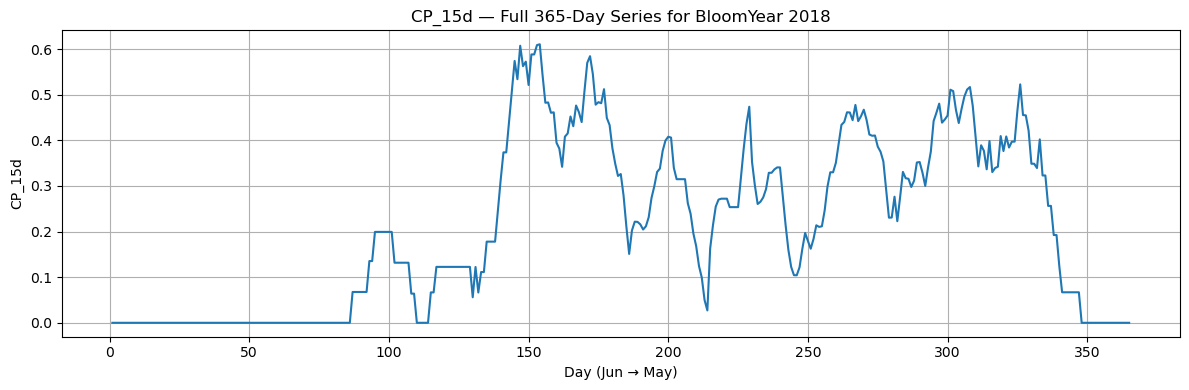

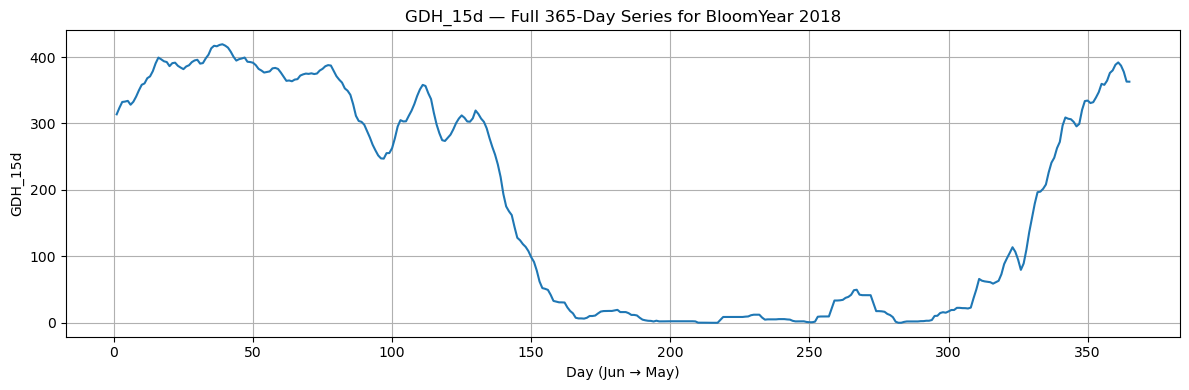

In [38]:
# Load the processed dataset
in_path = os.path.join(outputs_dir, "Daily_CP_GDH_15daySmooth_BloomYear_LeapAdj.csv")


df = pd.read_csv(in_path)
df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")

# Choose target BloomYear (CHANGE THIS IF YOU WANT ANOTHER YEAR)
target_year = 2018

# Extract the 365-day series
sub = df[df["BloomYear"] == target_year].sort_values("DATE")

if len(sub) != 365:
    print(f"BloomYear {target_year} has {len(sub)} days. It is not complete.")
else:
    cp_series = sub["CP_15d"].tolist()
    gdh_series = sub["GDH_15d"].tolist()

    # Plot CP_15d (its own separate plot)
    plt.figure(figsize=(12, 4))
    plt.plot(range(1, 366), cp_series)  # no specific colors
    plt.title(f"CP_15d — Full 365-Day Series for BloomYear {target_year}")
    plt.xlabel("Day (Jun → May)")
    plt.ylabel("CP_15d")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot GDH_15d (its own separate plot)
    plt.figure(figsize=(12, 4))
    plt.plot(range(1, 366), gdh_series)
    plt.title(f"GDH_15d — Full 365-Day Series for BloomYear {target_year}")
    plt.xlabel("Day (Jun → May)")
    plt.ylabel("GDH_15d")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# HN: in above plot 

you can easily do the x-axis easy to read. just set the ticks to june, july, etc. Human readable.

In [39]:
# --------------------------------------------------------
# BLOCK 14: Build X_chill, X_heat, and y_bloom for PLS
#           Only BloomYears with 365 days AND Bloom_DOY
# --------------------------------------------------------

# === 1) File paths ===
# Input: leap-adjusted smoothed daily data
in_daily = os.path.join(outputs_dir, "Daily_CP_GDH_15daySmooth_BloomYear_LeapAdj.csv")

# Input: bloom DOY data (created in Block 1)
in_bloom = os.path.join(outputs_dir, "selected_stage_doy.csv")

# Outputs
out_X_chill = os.path.join(outputs_dir, "X_chill.csv")
out_X_heat  = os.path.join(outputs_dir, "X_heat.csv")
out_y_bloom = os.path.join(outputs_dir, "y_bloom.csv")

# === 2) Load datasets ===
df = pd.read_csv(in_daily)
df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")

bloom = pd.read_csv(in_bloom)
# Keep only rows with valid DOY
bloom = bloom.dropna(subset=["DOY"]).copy()
bloom["Year"] = bloom["Year"].astype(int)

# === 3) Sort daily data just in case ===
df = df.sort_values(["BloomYear", "DATE"]).reset_index(drop=True)

# === 4) Get list of BloomYears ===
years = sorted(df["BloomYear"].unique())

X_chill_rows = []
X_heat_rows  = []
y_rows       = []

skipped_few_days   = []   # years with != 365 days
skipped_no_bloom   = []   # years without Bloom_DOY
used               = []   # years used in all three matrices

for Y in years:
    sub = df[df["BloomYear"] == Y].sort_values("DATE")

    # Must have exactly 365 rows
    if len(sub) != 365:
        skipped_few_days.append(Y)
        continue

    # Find Bloom DOY for this BloomYear
    bloom_row = bloom[bloom["Year"] == Y]

    # If no unique Bloom_DOY for this year, skip it completely
    if len(bloom_row) != 1 or pd.isna(bloom_row["DOY"].iloc[0]):
        skipped_no_bloom.append(Y)
        continue

    bloom_doy = int(bloom_row["DOY"].iloc[0])

    # This year is valid: 365 days + Bloom_DOY
    used.append(Y)

    # Extract the 365-day CP and GDH series
    cp_series  = sub["CP_15d"].tolist()
    gdh_series = sub["GDH_15d"].tolist()

    # Add to matrices (each row: [BloomYear, D1, D2, ... D365])
    X_chill_rows.append([Y] + cp_series)
    X_heat_rows.append([Y] + gdh_series)

    # Add Bloom_DOY row
    y_rows.append([Y, bloom_doy])

# === 5) Build final DataFrames ===

# Column names for X matrices
cols = ["BloomYear"] + [f"D{i}" for i in range(1, 366)]

X_chill_df = pd.DataFrame(X_chill_rows, columns=cols)
X_heat_df  = pd.DataFrame(X_heat_rows , columns=cols)
y_bloom_df = pd.DataFrame(y_rows      , columns=["BloomYear", "Bloom_DOY"])

# === 6) Save outputs ===
X_chill_df.to_csv(out_X_chill, index=False)
X_heat_df.to_csv(out_X_heat,   index=False)
y_bloom_df.to_csv(out_y_bloom, index=False)

# === 7) Print summary ===
print("\n======================")
print("BLOCK 14 SUMMARY")
print("======================")
print("Total BloomYears found                           :", len(years))
print("BloomYears used (365 days AND Bloom_DOY)         :", len(used))
print("BloomYears skipped (not 365 days)                :", len(skipped_few_days))
print("BloomYears skipped (no Bloom_DOY)                :", len(skipped_no_bloom))
print("Used BloomYears                                  :", used)
print("Skipped (not 365 days)                           :", skipped_few_days)
print("Skipped (no Bloom_DOY)                           :", skipped_no_bloom)

print("\nSaved:")
print(out_X_chill)
print(out_X_heat)
print(out_y_bloom)


BLOCK 14 SUMMARY
Total BloomYears found                           : 46
BloomYears used (365 days AND Bloom_DOY)         : 25
BloomYears skipped (not 365 days)                : 2
BloomYears skipped (no Bloom_DOY)                : 19
Used BloomYears                                  : [np.int64(1997), np.int64(1998), np.int64(1999), np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021)]
Skipped (not 365 days)                           : [np.int64(1979), np.int64(2024)]
Skipped (no Bloom_DOY)                           : [np.int64(1980), np.int64(1981), np.int64(1982), np.int64(1983), np.int64(1984), np.int64(1985), np.int64(1986), np.int64(1987), np.int64(1988), np.int64(1989), np.int64(1990), np.

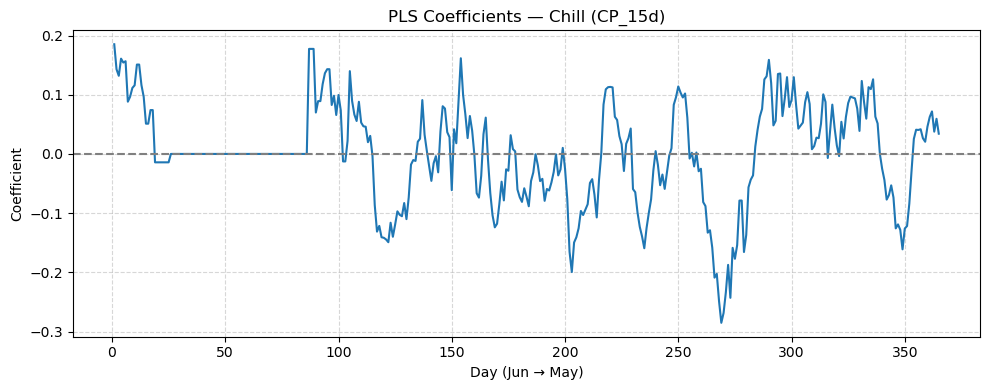

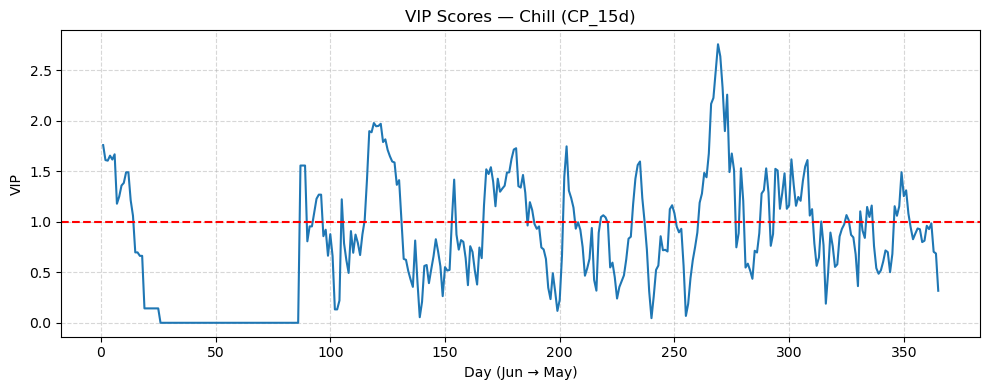

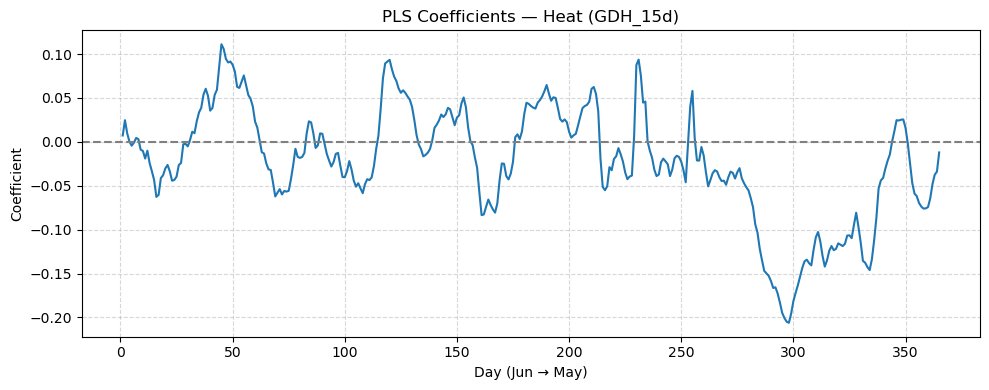

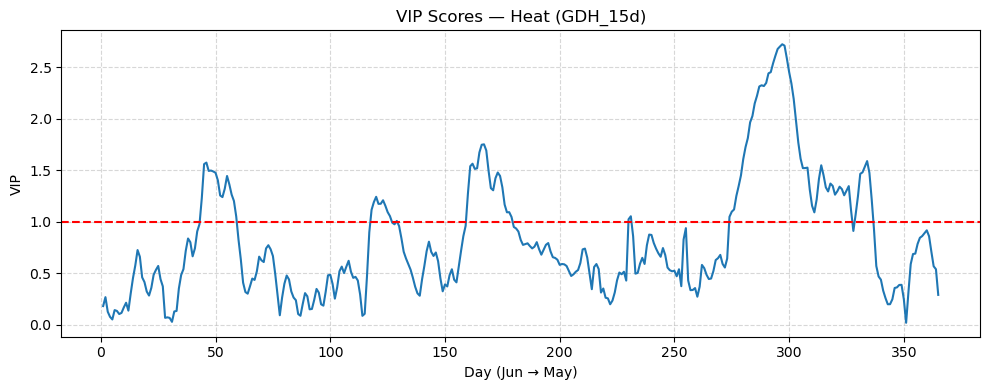

✅ BLOCK 15 completed successfully.


In [40]:
# --------------------------------------------------------
# BLOCK 15: PLS for Chill (CP_15d) and Heat (GDH_15d)
#           Generates Coefficients + VIP Scores
# --------------------------------------------------------

# === 1) File paths ===
X_chill_path = os.path.join(outputs_dir, "X_chill.csv")
X_heat_path  = os.path.join(outputs_dir, "X_heat.csv")
y_path       = os.path.join(outputs_dir, "y_bloom.csv")


# === 2) Load data ===
X_chill_df = pd.read_csv(X_chill_path)
X_heat_df  = pd.read_csv(X_heat_path)
y_df       = pd.read_csv(y_path)


# === 3) VIP calculation (correct for sklearn >=1.3) ===
# HN: no function here anymore
def compute_vip(pls_model, X_scaled):
    """
    Compute VIP scores for a fitted PLSRegression model.
    Supports the new sklearn structure where y_loadings_ = (1, n_components)
    """

    T = pls_model.x_scores_          # shape: (n_samples, n_components)
    W = pls_model.x_weights_         # shape: (n_features, n_components)
    Q = pls_model.y_loadings_        # shape: (1, n_components)

    # Ensure Q is (n_components,)
    if Q.ndim == 2:
        Q = Q.flatten()

    n_features = W.shape[0]
    n_components = W.shape[1]

    # SSY for each component
    ssy = np.zeros(n_components)
    for k in range(n_components):
        t_k = T[:, k]
        q_k = Q[k]
        ssy[k] = np.sum(t_k ** 2) * (q_k ** 2)

    total_ssy = np.sum(ssy)

    vip = np.zeros(n_features)

    for j in range(n_features):
        weight_sum = 0.0
        for k in range(n_components):
            weight_sum += (W[j, k] ** 2) * ssy[k]
        vip[j] = np.sqrt(n_features * weight_sum / total_ssy)

    return vip



# === 4) Function to run PLS for a dataset (Chill or Heat) ===
def run_pls(X_df, y_df, label="Chill"):

    # Merge X and y by BloomYear
    merged = pd.merge(X_df, y_df, on="BloomYear", how="inner")
    merged = merged.dropna(subset=["Bloom_DOY"])

    feature_cols = [c for c in merged.columns if c.startswith("D")]
    X = merged[feature_cols].values
    y = merged["Bloom_DOY"].values.reshape(-1,1)

    # Scale X
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Fit PLS model
    pls = PLSRegression(n_components=n_components)
    pls.fit(X_scaled, y)

    # Regression coefficients
    coef = pls.coef_.ravel()

    # VIP scores
    vip = compute_vip(pls, X_scaled)

    days = np.arange(1, len(coef) + 1)

    coef_df = pd.DataFrame({"Day": days, "Coefficient": coef})
    vip_df  = pd.DataFrame({"Day": days, "VIP": vip})

    # === Plot coefficients ===
    plt.figure(figsize=(10,4))
    plt.plot(days, coef)
    plt.axhline(0, linestyle="--", color="gray")
    plt.title(f"PLS Coefficients — {label}")
    plt.xlabel("Day (Jun → May)")
    plt.ylabel("Coefficient")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # === Plot VIP ===
    plt.figure(figsize=(10,4))
    plt.plot(days, vip)
    plt.axhline(1.0, linestyle="--", color="red")
    plt.title(f"VIP Scores — {label}")
    plt.xlabel("Day (Jun → May)")
    plt.ylabel("VIP")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    return coef_df, vip_df



# === 5) Run PLS for Chill ===
coef_chill_df, vip_chill_df = run_pls(
    X_chill_df,
    y_df,
    label="Chill (CP_15d)",
)

# === 6) Run PLS for Heat ===
coef_heat_df, vip_heat_df = run_pls(
    X_heat_df,
    y_df,
    label="Heat (GDH_15d)",
)


# === 7) Save results ===
coef_chill_df.to_csv(os.path.join(outputs_dir, "PLS_Chill_Coefficients.csv"), index=False)
vip_chill_df.to_csv(os.path.join(outputs_dir, "PLS_Chill_VIP.csv"), index=False)

coef_heat_df.to_csv(os.path.join(outputs_dir, "PLS_Heat_Coefficients.csv"), index=False)
vip_heat_df.to_csv(os.path.join(outputs_dir, "PLS_Heat_VIP.csv"), index=False)

print("✅ BLOCK 15 completed successfully.")

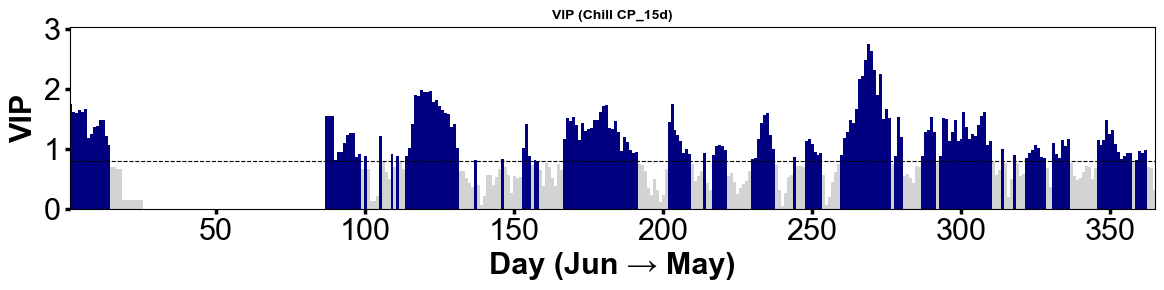

In [41]:
# =============================================
# CHILL VIP BAR PLOT (Like Fig.1 of the article)
# =============================================

# Load VIP data
vip_path = os.path.join(outputs_dir, "PLS_Chill_VIP.csv")
vip_df = pd.read_csv(vip_path)

days = vip_df["Day"]
vip = vip_df["VIP"]

# threshold
th = vip_th

plt.figure(figsize=(12, 3))

# Colors: navy for VIP > vip_th, grey otherwise
colors = np.where(vip > th, "navy", "lightgrey")

plt.bar(days, vip, color=colors, width=1.0)
plt.axhline(th, color="black", linestyle="--", linewidth=0.8)

# Apply text fonts
plt.title("VIP (Chill CP_15d)", **font_dict["title"])
plt.xlabel("Day (Jun → May)", **font_dict["x_label"])
plt.ylabel("VIP", **font_dict["y_label"])

plt.xticks(fontsize=font_dict["tick_labels"]["labelsize"],
           fontfamily=font_dict["tick_labels"]["fontfamily"])

plt.yticks(fontsize=font_dict["tick_labels"]["labelsize"],
           fontfamily=font_dict["tick_labels"]["fontfamily"])

plt.xlim(1, 365)
plt.ylim(0, max(vip) * 1.1)
# Make the tick marks thicker
plt.tick_params(axis="both", width=2.5)

plt.tight_layout()
plt.grid(False)
plt.show()

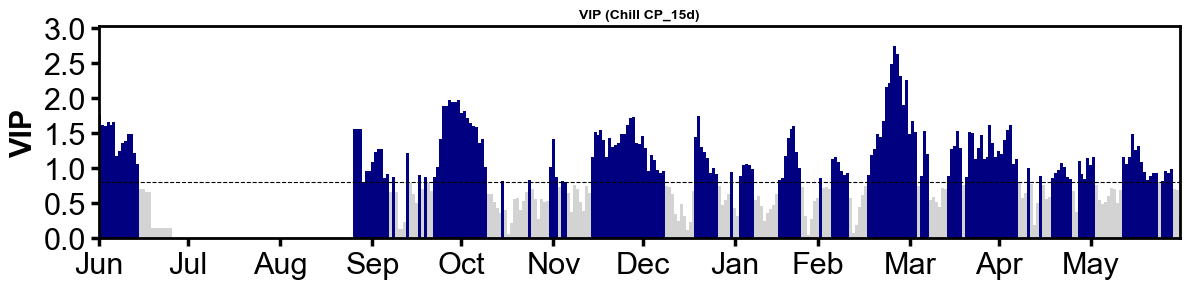

In [42]:
# =============================================
# CHILL VIP BAR PLOT — with MONTH LABELS
# =============================================

vip_path = os.path.join(outputs_dir, "PLS_Chill_VIP.csv")
vip_df = pd.read_csv(vip_path)

days = vip_df["Day"]
vip = vip_df["VIP"]

th = vip_th  # threshold

plt.figure(figsize=(12, 3))

colors = np.where(vip > th, "navy", "lightgrey")
plt.bar(days, vip, color=colors, width=1.0)

plt.axhline(th, color="black", linestyle="--", linewidth=0.8)

# ============================
# Apply font dictionary
# ============================
plt.title("VIP (Chill CP_15d)", **font_dict["title"])
plt.ylabel("VIP", **font_dict["y_label"])

plt.xlim(1, 365)
plt.ylim(0, vip.max() * 1.1)

# ============================
# Month labels
# ============================
month_starts = [1, 31, 62, 93, 123, 154,
                184, 215, 243, 274, 304, 335]
month_labels = ["Jun","Jul","Aug","Sep","Oct","Nov","Dec",
                "Jan","Feb","Mar","Apr","May"]

plt.xticks(
    month_starts,
    month_labels,
    fontsize=font_dict["tick_labels"]["labelsize"],
    fontfamily=font_dict["tick_labels"]["fontfamily"]
)
plt.yticks(
    fontsize=font_dict["tick_labels"]["labelsize"],
    fontfamily=font_dict["tick_labels"]["fontfamily"]
)

# ============================
# Thicker tick marks + spines
# ============================
plt.tick_params(axis="both", width=2.5, length=6)

for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

plt.grid(False)
plt.tight_layout()

plt.savefig("Pictures/VIP_Chill_CP15d.jpg", dpi=300, bbox_inches="tight")
plt.show()

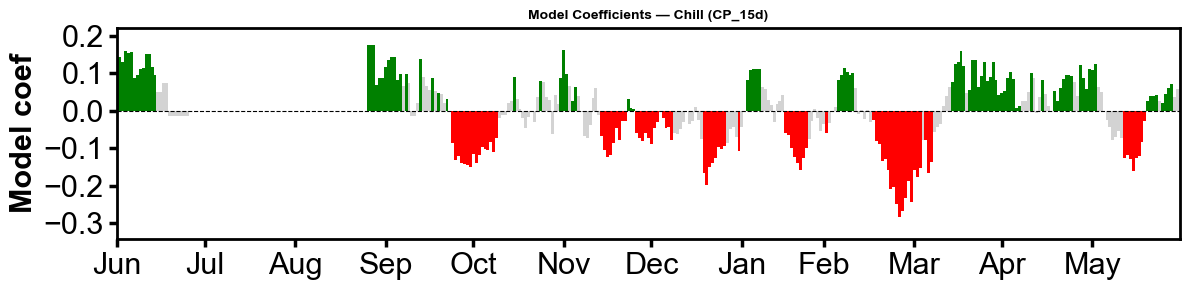

In [43]:
# ============================
# Font dictionary for poster
# ============================

coef_path = os.path.join(outputs_dir, "PLS_Chill_Coefficients.csv")
vip_path  = os.path.join(outputs_dir, "PLS_Chill_VIP.csv")

coef_df = pd.read_csv(coef_path)
vip_df  = pd.read_csv(vip_path)

days = coef_df["Day"]
coeff = coef_df["Coefficient"]
vip   = vip_df["VIP"]

th = vip_th  # VIP threshold

# ============================
# Define colors based on VIP & sign
# ============================
colors = []
for c, v in zip(coeff, vip):
    if v <= th:
        colors.append("lightgrey")             # low importance
    else:
        if c > 0:
            colors.append("green")             # positive & important
        else:
            colors.append("red")               # negative & important

plt.figure(figsize=(12, 3))

# Bar plot for coefficients
plt.bar(days, coeff, color=colors, width=1.0)

plt.axhline(0, color="black", linestyle="--", linewidth=0.8)

# ============================
# Apply font dictionary
# ============================
plt.title("Model Coefficients — Chill (CP_15d)", **font_dict["title"])
plt.ylabel("Model coef", **font_dict["y_label"])

plt.xlim(1, 365)
plt.ylim(coeff.min() * 1.2, coeff.max() * 1.2)

# ============================
# Month labels
# ============================
month_starts = [1, 31, 62, 93, 123, 154,
                184, 215, 243, 274, 304, 335]
month_labels = ["Jun","Jul","Aug","Sep","Oct","Nov","Dec",
                "Jan","Feb","Mar","Apr","May"]

plt.xticks(
    month_starts,
    month_labels,
    fontsize=font_dict["tick_labels"]["labelsize"],
    fontfamily=font_dict["tick_labels"]["fontfamily"]
)
plt.yticks(
    fontsize=font_dict["tick_labels"]["labelsize"],
    fontfamily=font_dict["tick_labels"]["fontfamily"]
)

# ============================
# Thicker tick marks + spines
# ============================
plt.tick_params(axis="both", width=2.5, length=6)

for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

plt.grid(False)
plt.tight_layout()
plt.savefig("Pictures/Model Coefficients — Chill (CP_15d).jpg", dpi=300, bbox_inches="tight")
plt.show()

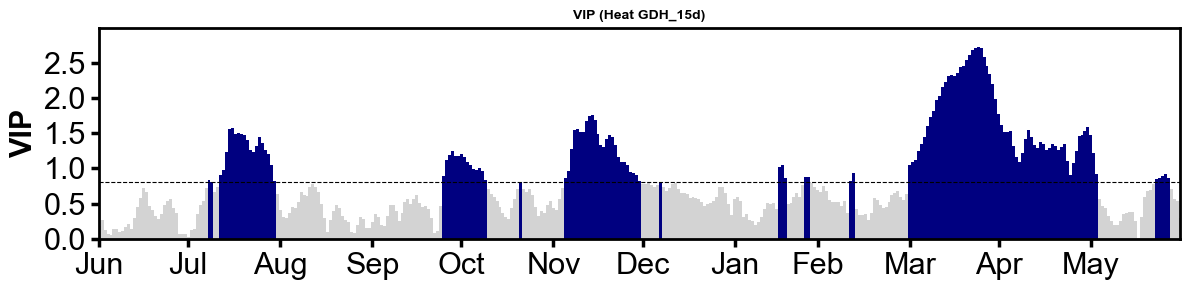

In [44]:
# =============================================
# HEAT VIP BAR PLOT — Like Fig.1 (Right side)
# =============================================

# ============================
# Load Heat VIP data
# ============================
vip_path = os.path.join(outputs_dir, "PLS_Heat_VIP.csv")
vip_df = pd.read_csv(vip_path)

days = vip_df["Day"]
vip  = vip_df["VIP"]

th = vip_th

plt.figure(figsize=(12, 3))

colors = np.where(vip > th, "navy", "lightgrey")

plt.bar(days, vip, color=colors, width=1.0)
plt.axhline(th, color="black", linestyle="--", linewidth=0.8)

# ============================
# Apply poster fonts
# ============================
plt.title("VIP (Heat GDH_15d)", **font_dict["title"])
plt.ylabel("VIP", **font_dict["y_label"])

plt.xlim(1, 365)
plt.ylim(0, vip.max() * 1.1)

# ============================
# Month labels
# ============================
month_starts = [1, 31, 62, 93, 123, 154,
                184, 215, 243, 274, 304, 335]
month_labels = ["Jun","Jul","Aug","Sep","Oct","Nov","Dec",
                "Jan","Feb","Mar","Apr","May"]

plt.xticks(
    month_starts, month_labels,
    fontsize=font_dict["tick_labels"]["labelsize"],
    fontfamily=font_dict["tick_labels"]["fontfamily"]
)

plt.yticks(
    fontsize=font_dict["tick_labels"]["labelsize"],
    fontfamily=font_dict["tick_labels"]["fontfamily"]
)

# ============================
# Thicker ticks + spines
# ============================
plt.tick_params(axis="both", width=2.5, length=6)

for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

plt.grid(False)
plt.tight_layout()
plt.savefig("Pictures/VIP (Heat GDH_15d).jpg", dpi=300, bbox_inches="tight")
plt.show()



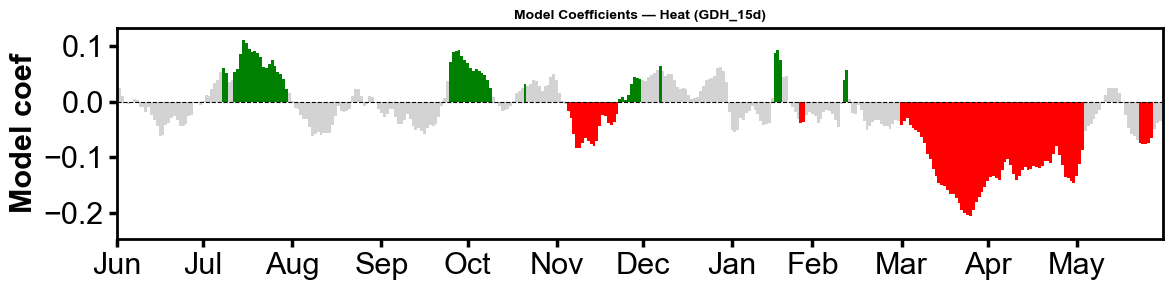

In [45]:
# =============================================
# HEAT MODEL COEFFICIENTS — Like Fig.1 (Right)
# =============================================

# ============================
# Load Coef + VIP
# ============================
coef_path = os.path.join(outputs_dir, "PLS_Heat_Coefficients.csv")
vip_path  = os.path.join(outputs_dir, "PLS_Heat_VIP.csv")

coef_df = pd.read_csv(coef_path)
vip_df  = pd.read_csv(vip_path)

days  = coef_df["Day"]
coeff = coef_df["Coefficient"]
vip   = vip_df["VIP"]

th = vip_th

# ============================
# Build color array using VIP + sign
# ============================
colors = []
for c, v in zip(coeff, vip):
    if v <= th:
        colors.append("lightgrey")    # low importance
    else:
        if c > 0:
            colors.append("green")    # positive & important
        else:
            colors.append("red")      # negative & important

plt.figure(figsize=(12, 3))

plt.bar(days, coeff, color=colors, width=1.0)
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)

# ============================
# Apply font dictionary
# ============================
plt.title("Model Coefficients — Heat (GDH_15d)", **font_dict["title"])
plt.ylabel("Model coef", **font_dict["y_label"])

plt.xlim(1, 365)
plt.ylim(coeff.min() * 1.2, coeff.max() * 1.2)

# ============================
# Month labels
# ============================
month_starts = [1, 31, 62, 93, 123, 154,
                184, 215, 243, 274, 304, 335]
month_labels = ["Jun","Jul","Aug","Sep","Oct","Nov","Dec",
                "Jan","Feb","Mar","Apr","May"]

plt.xticks(
    month_starts,
    month_labels,
    fontsize=font_dict["tick_labels"]["labelsize"],
    fontfamily=font_dict["tick_labels"]["fontfamily"]
)

plt.yticks(
    fontsize=font_dict["tick_labels"]["labelsize"],
    fontfamily=font_dict["tick_labels"]["fontfamily"]
)

# ============================
# Thicker ticks + spines
# ============================
plt.tick_params(axis="both", width=2.5, length=6)

for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

plt.grid(False)
plt.tight_layout()
plt.savefig("Pictures/Model Coefficients — Heat (GDH_15d).jpg", dpi=300, bbox_inches="tight")
plt.show()

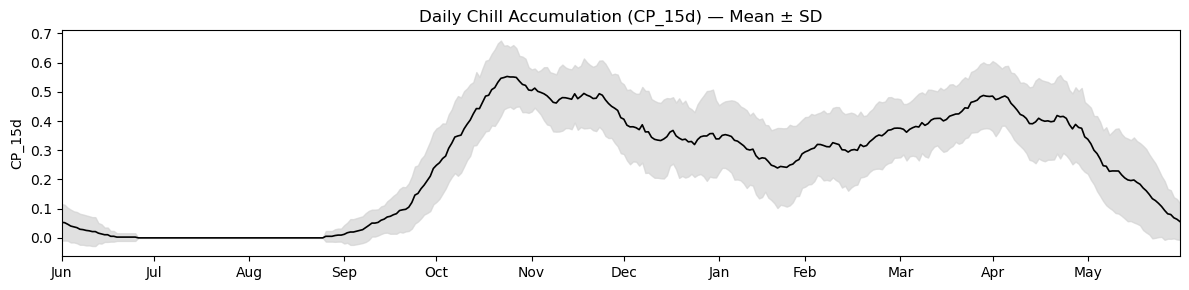

In [46]:
# =======================================================
# CHILL — Daily CP Accumulation (mean ± SD)
# =======================================================

# Load X_chill (365 values per BloomYear)
chill_path = os.path.join(outputs_dir, "X_chill.csv")
chill_df = pd.read_csv(chill_path)

# Extract only D1..D365 columns
day_cols = [c for c in chill_df.columns if c.startswith("D")]
X = chill_df[day_cols].values      # shape: (n_years, 365)

# Compute mean and standard deviation
mean_chill = X.mean(axis=0)
std_chill  = X.std(axis=0)

days = np.arange(1, 366)

plt.figure(figsize=(12,3))

# Plot mean line
plt.plot(days, mean_chill, color="black", linewidth=1.2)

# Plot ±1 SD shading (grey)
plt.fill_between(days,
                 mean_chill - std_chill,
                 mean_chill + std_chill,
                 color="lightgrey", alpha=0.7)

plt.title("Daily Chill Accumulation (CP_15d) — Mean ± SD")
plt.ylabel("CP_15d")
plt.xlim(1,365)

# Month labels
month_starts = [1, 31, 62, 93, 123, 154,
                184, 215, 243, 274, 304, 335]
month_labels = ["Jun","Jul","Aug","Sep","Oct","Nov","Dec",
                "Jan","Feb","Mar","Apr","May"]

plt.xticks(month_starts, month_labels)

plt.grid(False)
plt.tight_layout()
# plt.savefig("Pictures/Daily Chill Accumulation (CP_15d) — Mean ± SD.jpg", dpi=300, bbox_inches="tight")
plt.show()

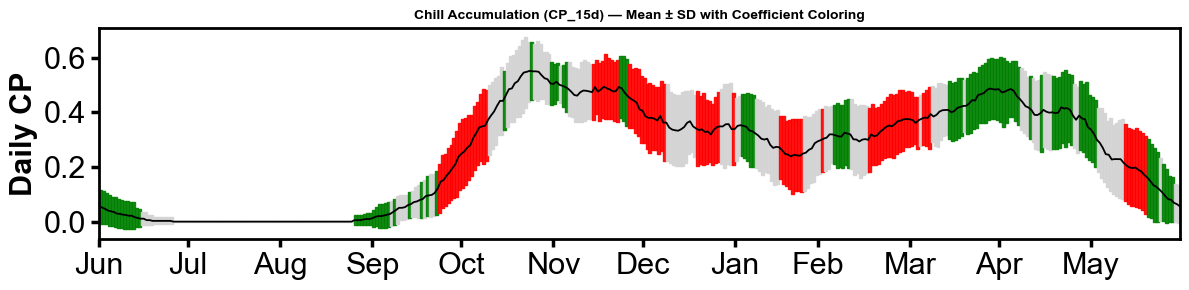

In [47]:
# =======================================================
# CHILL — Daily CP Accumulation + Colored SD (Article Style)
# =======================================================


# ============================
# Load data
# ============================
chill_path = os.path.join(outputs_dir, "X_chill.csv")
chill_df = pd.read_csv(chill_path)

coef_df = pd.read_csv(os.path.join(outputs_dir, "PLS_Chill_Coefficients.csv"))
vip_df  = pd.read_csv(os.path.join(outputs_dir, "PLS_Chill_VIP.csv"))

coeff = coef_df["Coefficient"].values
vip   = vip_df["VIP"].values

day_cols = [c for c in chill_df.columns if c.startswith("D")]
X = chill_df[day_cols].values     # years × 365

# ============================
# Mean & SD across years
# ============================
mean_chill = X.mean(axis=0)
std_chill  = X.std(axis=0)

days = np.arange(1, 366)

# ============================
# Determine day color from PLS
# ============================
colors = []
for c, v in zip(coeff, vip):
    if v <= vip_th:
        colors.append("lightgrey")
    else:
        colors.append("green" if c > 0 else "red")

# ============================
# Plot figure
# ============================
plt.figure(figsize=(12, 3))

# SD shading by day (PLS-colored)
for i in range(365):
    plt.fill_between(
        [i+1, i+2],
        mean_chill[i] - std_chill[i],
        mean_chill[i] + std_chill[i],
        color=colors[i],
        alpha=0.9
    )

# Mean chill line
plt.plot(days, mean_chill, color="black", linewidth=1.3)

# ============================
# Poster text formatting
# ============================
plt.title("Chill Accumulation (CP_15d) — Mean ± SD with Coefficient Coloring",
          **font_dict["title"])
plt.ylabel("Daily CP", **font_dict["y_label"])

plt.xlim(1, 365)

# Month labels
month_starts = [1, 31, 62, 93, 123, 154,
                184, 215, 243, 274, 304, 335]
month_labels = ["Jun","Jul","Aug","Sep","Oct","Nov","Dec",
                "Jan","Feb","Mar","Apr","May"]

plt.xticks(month_starts, month_labels,
           fontsize=font_dict["tick_labels"]["labelsize"],
           fontfamily=font_dict["tick_labels"]["fontfamily"])

plt.yticks(
    fontsize=font_dict["tick_labels"]["labelsize"],
    fontfamily=font_dict["tick_labels"]["fontfamily"]
)

# Thicker ticks + spines
plt.tick_params(axis="both", width=2.5, length=6)
for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

plt.grid(False)
plt.tight_layout()
plt.savefig("Pictures/Chill Accumulation (CP_15d) — Mean ± SD with Coefficient Coloring.jpg", dpi=300, bbox_inches="tight")
plt.show()

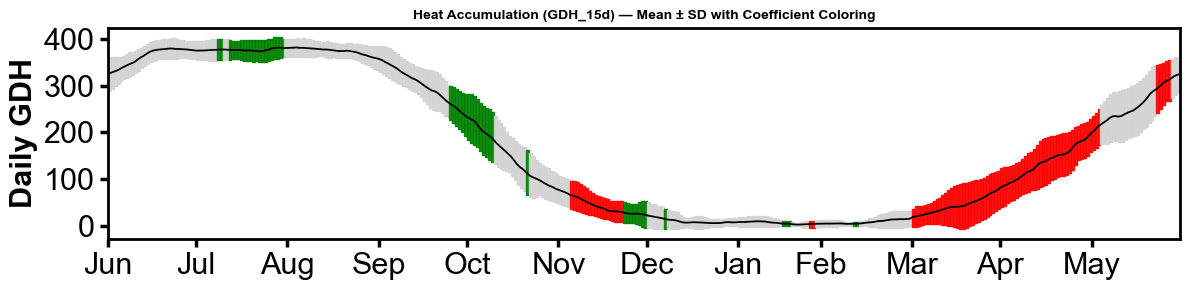

In [48]:
# =======================================================
# HEAT — Daily CP Accumulation + Colored SD (Article Style)
# =======================================================

# ============================
# Load data
# ============================
heat_path = os.path.join(outputs_dir, "X_heat.csv")
heat_df = pd.read_csv(heat_path)

coef_df = pd.read_csv(os.path.join(outputs_dir, "PLS_Heat_Coefficients.csv"))
vip_df  = pd.read_csv(os.path.join(outputs_dir, "PLS_Heat_VIP.csv"))

coeff = coef_df["Coefficient"].values
vip   = vip_df["VIP"].values

day_cols = [c for c in heat_df.columns if c.startswith("D")]
X = heat_df[day_cols].values   # years × 365

# ============================
# Mean & SD across years
# ============================
mean_heat = X.mean(axis=0)
std_heat  = X.std(axis=0)

days = np.arange(1, 366)

# ============================
# Determine PLS-based shading colors
# ============================
colors = []
for c, v in zip(coeff, vip):
    if v <= vip_th:
        colors.append("lightgrey")
    else:
        colors.append("green" if c > 0 else "red")

# ============================
# Plot (POSTER FORMAT)
# ============================
plt.figure(figsize=(12, 3))

# SD shading
for i in range(365):
    plt.fill_between(
        [i+1, i+2],
        mean_heat[i] - std_heat[i],
        mean_heat[i] + std_heat[i],
        color=colors[i],
        alpha=0.90
    )

# Mean line
plt.plot(days, mean_heat, color="black", linewidth=1.3)

# Titles and labels
plt.title("Heat Accumulation (GDH_15d) — Mean ± SD with Coefficient Coloring",
          **font_dict["title"])
plt.ylabel("Daily GDH", **font_dict["y_label"])

plt.xlim(1, 365)

# Month labels (Jul → Jun)
month_starts = [1, 31, 62, 93, 123, 154,
                184, 215, 243, 274, 304, 335]
month_labels = ["Jun","Jul","Aug","Sep","Oct","Nov","Dec",
                "Jan","Feb","Mar","Apr","May"]

plt.xticks(
    month_starts, month_labels,
    fontsize=font_dict["tick_labels"]["labelsize"],
    fontfamily=font_dict["tick_labels"]["fontfamily"]
)

plt.yticks(
    fontsize=font_dict["tick_labels"]["labelsize"],
    fontfamily=font_dict["tick_labels"]["fontfamily"]
)

# Thick ticks + thick spines (poster visibility)
plt.tick_params(axis="both", width=2.5, length=6)

for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

plt.grid(False)
plt.tight_layout()
plt.savefig("Pictures/Heat Accumulation (GDH_15d) — Mean ± SD with Coefficient Coloring.jpg", dpi=300, bbox_inches="tight")
plt.show()

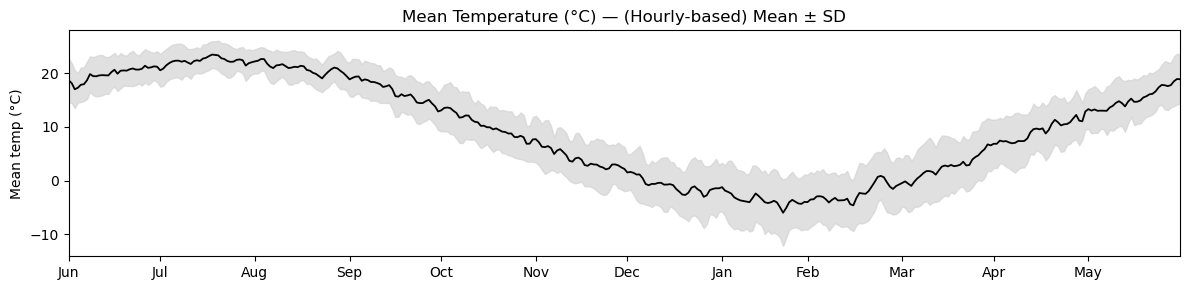

In [49]:
# =======================================================
# MEAN TEMPERATURE — based on hourly EST temperature
# (this matches the paper exactly)
# =======================================================

# Load hourly temperature file
hourly_path = os.path.join(outputs_dir, "WeatherData_Wenatchee_Hourly.csv")
df = pd.read_csv(hourly_path)
df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")
df["DOY"] = df["DATE"].dt.dayofyear

# Compute daily mean temperature from hourly estimates
daily = df.groupby("DATE", as_index=False).agg(
    TMEAN=("TEMP_EST_C", "mean")
)

# Shift DOY so July=1
daily["DOY"] = daily["DATE"].dt.dayofyear
# daily["DOY_shift"] = daily["DOY"].apply(lambda x: x - 181 if x >= 181 else x + 184)    #************* For start from July
daily["DOY_shift"] = daily["DOY"].apply(lambda x: x - 152 if x >= 152 else x + 213)


# Group by shifted DOY across all years
mean_temp = daily.groupby("DOY_shift")["TMEAN"].mean().values
std_temp  = daily.groupby("DOY_shift")["TMEAN"].std().values

days = np.arange(1, 366)

# === Plot (Mean ± SD) ===

plt.figure(figsize=(12,3))

plt.plot(days, mean_temp, color="black", linewidth=1.3)
plt.fill_between(days, mean_temp - std_temp, mean_temp + std_temp,
                 color="lightgrey", alpha=0.7)

plt.title("Mean Temperature (°C) — (Hourly-based) Mean ± SD")
plt.ylabel("Mean temp (°C)")
plt.xlim(1, 365)

month_starts = [1, 31, 62, 93, 123, 154,
                184, 215, 243, 274, 304, 335]
month_labels = ["Jun","Jul","Aug","Sep","Oct","Nov","Dec",
                "Jan","Feb","Mar","Apr","May"]

plt.xticks(month_starts, month_labels)

plt.grid(False)
plt.tight_layout()
plt.show()

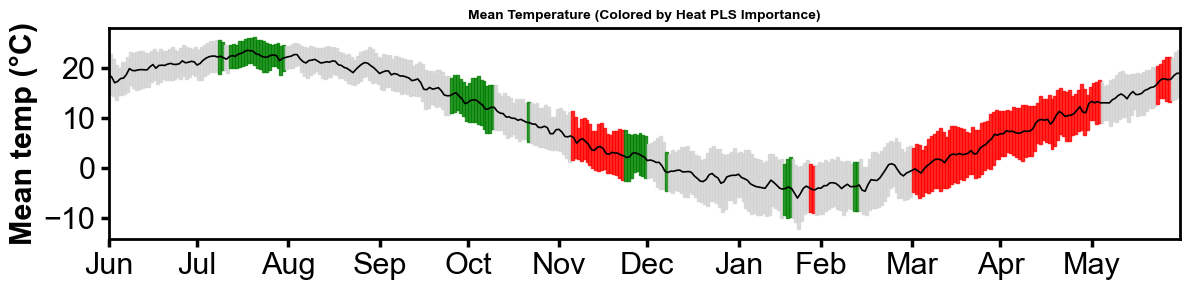

In [50]:
# =======================================================
# Mean Temperature (Hourly-based) + Colored SD band (PLS)
# Based On Heat Coeff
# =======================================================

# === 1. Load hourly temperature data ===
hourly_path = os.path.join(outputs_dir, "WeatherData_Wenatchee_Hourly.csv")
df = pd.read_csv(hourly_path)

df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")
df["DOY"] = df["DATE"].dt.dayofyear

# === 2. Daily mean temp ===
daily = df.groupby("DATE", as_index=False).agg(
    TMEAN=("TEMP_EST_C", "mean")
)

daily["DOY"] = daily["DATE"].dt.dayofyear
daily["DOY_shift"] = daily["DOY"].apply(lambda x: x - 152 if x >= 152 else x + 213)

# === 3. Mean ± SD across years ===
mean_temp = daily.groupby("DOY_shift")["TMEAN"].mean().values
std_temp  = daily.groupby("DOY_shift")["TMEAN"].std().values

days = np.arange(1, 366)

# === 4. Load PLS Heat coef + VIP ===
coef_heat = coef_heat_df.iloc[:,1].values   # coefficients
vip_heat  = vip_heat_df.iloc[:,1].values    # VIP

# === 5. Choose shading color ===
shade_colors = []
for c, v in zip(coef_heat, vip_heat):
    if v < vip_th:
        shade_colors.append("lightgrey")
    else:
        shade_colors.append("green" if c > 0 else "red")

# === 6. Plot daywise shaded SD band ===
plt.figure(figsize=(12, 3))

for i in range(365):
    plt.fill_between(
        [i+1, i+2],
        [mean_temp[i] - std_temp[i], mean_temp[i] - std_temp[i]],
        [mean_temp[i] + std_temp[i], mean_temp[i] + std_temp[i]],
        color=shade_colors[i],
        alpha=0.8
    )

# === 7. Mean temp line ===
plt.plot(days, mean_temp, color="black", linewidth=1.2)

# ============================
# Apply poster fonts
# ============================
plt.title("Mean Temperature (Colored by Heat PLS Importance)", **font_dict["title"])
plt.ylabel("Mean temp (°C)", **font_dict["y_label"])

plt.xlim(1, 365)

# ============================
# Month labels
# ============================
month_starts = [1, 31, 62, 93, 123, 154,
                184, 215, 243, 274, 304, 335]
month_labels = ["Jun","Jul","Aug","Sep","Oct","Nov","Dec",
                "Jan","Feb","Mar","Apr","May"]


plt.xticks(
    month_starts,
    month_labels,
    fontsize=font_dict["tick_labels"]["labelsize"],
    fontfamily=font_dict["tick_labels"]["fontfamily"]
)

plt.yticks(
    fontsize=font_dict["tick_labels"]["labelsize"],
    fontfamily=font_dict["tick_labels"]["fontfamily"]
)

# ============================
# Thicker ticks + spines
# ============================
plt.tick_params(axis="both", width=2.5, length=6)

for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

plt.grid(False)
plt.tight_layout()
plt.savefig("Pictures/Mean Temperature (Colored by Heat PLS Importance).jpg", dpi=300, bbox_inches="tight")
plt.show()

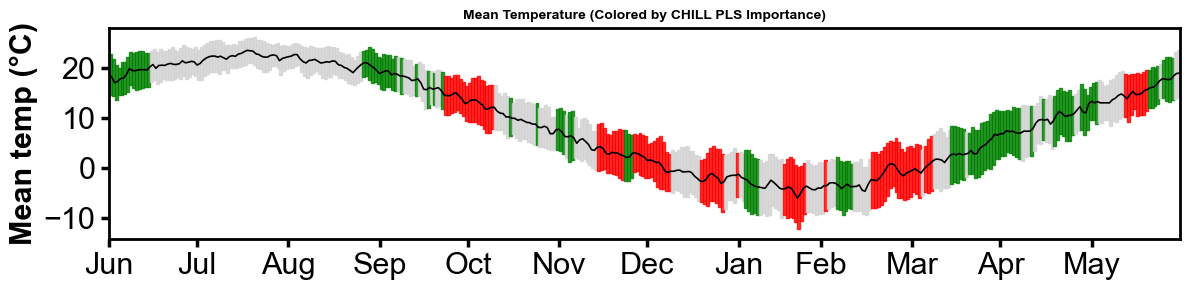

In [51]:
# =======================================================
# Mean Temperature (Hourly-based) + PLS Coloring (CHILL)
#  Based On Chill Coeff
# =======================================================

# === 1. Load hourly temperature data ===
hourly_path = os.path.join(outputs_dir, "WeatherData_Wenatchee_Hourly.csv")
df = pd.read_csv(hourly_path)

df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")
df["DOY"] = df["DATE"].dt.dayofyear

# === 2. Daily mean temp ===
daily = df.groupby("DATE", as_index=False).agg(
    TMEAN=("TEMP_EST_C", "mean")
)

# Shift DOY so July = 1
daily["DOY"] = daily["DATE"].dt.dayofyear
daily["DOY_shift"] = daily["DOY"].apply(lambda x: x - 152 if x >= 152 else x + 213)

# === 3. Mean ± SD across years ===
mean_temp = daily.groupby("DOY_shift")["TMEAN"].mean().values
std_temp  = daily.groupby("DOY_shift")["TMEAN"].std().values

days = np.arange(1, 366)

# === 4. Load CHILL PLS Coef + VIP ===
coef_chill = coef_chill_df.iloc[:, 1].values
vip_chill  = vip_chill_df.iloc[:, 1].values

# === 5. Determine shading colors ===
shade_colors = []
for c, v in zip(coef_chill, vip_chill):
    if v < vip_th:
        shade_colors.append("lightgrey")
    else:
        shade_colors.append("green" if c > 0 else "red")

# === 6. Plot SD band shading by day ===
plt.figure(figsize=(12, 3))

for i in range(365):
    plt.fill_between(
        [i+1, i+2],
        [mean_temp[i] - std_temp[i], mean_temp[i] - std_temp[i]],
        [mean_temp[i] + std_temp[i], mean_temp[i] + std_temp[i]],
        color=shade_colors[i],
        alpha=0.8
    )

# === 7. Plot mean temperature line ===
plt.plot(days, mean_temp, color="black", linewidth=1.2)

# ============================
# Apply poster fonts
# ============================
plt.title("Mean Temperature (Colored by CHILL PLS Importance)", **font_dict["title"])
plt.ylabel("Mean temp (°C)", **font_dict["y_label"])

plt.xlim(1, 365)

# ============================
# Month labels
# ============================
month_starts = [1, 31, 62, 93, 123, 154,
                184, 215, 243, 274, 304, 335]
month_labels = ["Jun","Jul","Aug","Sep","Oct","Nov","Dec",
                "Jan","Feb","Mar","Apr","May"]


plt.xticks(
    month_starts,
    month_labels,
    fontsize=font_dict["tick_labels"]["labelsize"],
    fontfamily=font_dict["tick_labels"]["fontfamily"]
)

plt.yticks(
    fontsize=font_dict["tick_labels"]["labelsize"],
    fontfamily=font_dict["tick_labels"]["fontfamily"]
)

# ============================
# Thicker ticks + spines
# ============================
plt.tick_params(axis="both", width=2.5, length=6)

for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

plt.grid(False)
plt.tight_layout()
plt.savefig("Pictures/Mean Temperature (Colored by CHILL PLS Importance).jpg", dpi=300, bbox_inches="tight")
plt.show()

In [52]:
# ---------------------------------------------------------
# Load VIP & Coefficient for CHILL
# ---------------------------------------------------------
vip_df = pd.read_csv(os.path.join(outputs_dir, "PLS_Chill_VIP.csv"))
coef_df = pd.read_csv(os.path.join(outputs_dir, "PLS_Chill_Coefficients.csv"))

vip = vip_df["VIP"].values
coef = coef_df["Coefficient"].values

# ---------------------------------------------------------
# Convert DOY-shift day → actual calendar date
# ---------------------------------------------------------
def day_to_date(day):
    """Convert shifted DOY (1–365) to calendar date."""
    month_starts = [
        (1,  "Jun"), (31, "Jul"), (62, "Aug"), (93, "Sep"),
        (123,"Oct"), (154,"Nov"), (184,"Dec"), (215,"Jan"),
        (243,"Feb"), (274,"Mar"), (304,"Apr"), (335,"May")
    ]

    for i in range(len(month_starts)-1):
        start_day, month = month_starts[i]
        next_start, _ = month_starts[i+1]

        if start_day <= day < next_start:
            return month, day - start_day + 1

    # return "Jun", day - 335 + 1
    start_day, month = month_starts[-1]   # (335, "May")
    return month, day - start_day + 1

# ---------------------------------------------------------
# Boolean rule: VIP > vip_th AND Coefficient < 0
# ---------------------------------------------------------
mask = (vip > vip_th) & (coef < 0)

segments = []
in_segment = False
start = None

for i in range(365):
    if mask[i] and not in_segment:
        in_segment = True
        start = i + 1
    elif not mask[i] and in_segment:
        in_segment = False
        end = i
        segments.append((start, end))

if in_segment:
    segments.append((start, 365))

# ---------------------------------------------------------
# Print with calendar date formatting
# ---------------------------------------------------------
print("Chill Segments where VIP > vip_th AND Coef < 0:\n")

for s, e in segments:
    month_s, day_s = day_to_date(s)
    month_e, day_e = day_to_date(e)

    print(f"→ From day {s} ({month_s} {day_s}) "
          f"to day {e} ({month_e} {day_e}) "
          f"— Length {e-s+1} days")

Chill Segments where VIP > vip_th AND Coef < 0:

→ From day 115 (Sep 23) to day 131 (Oct 9) — Length 17 days
→ From day 167 (Nov 14) to day 175 (Nov 22) — Length 9 days
→ From day 179 (Nov 26) to day 191 (Dec 8) — Length 13 days
→ From day 202 (Dec 19) to day 209 (Dec 26) — Length 8 days
→ From day 214 (Dec 31) to day 214 (Dec 31) — Length 1 days
→ From day 230 (Jan 16) to day 237 (Jan 23) — Length 8 days
→ From day 244 (Feb 2) to day 244 (Feb 2) — Length 1 days
→ From day 260 (Feb 18) to day 276 (Mar 3) — Length 17 days
→ From day 278 (Mar 5) to day 280 (Mar 7) — Length 3 days
→ From day 346 (May 12) to day 353 (May 19) — Length 8 days


In [53]:
# ---------------------------------------------------------
# Load VIP & Coefficient for HEAT (GDH)
# ---------------------------------------------------------
vip_df = pd.read_csv(os.path.join(outputs_dir, "PLS_Heat_VIP.csv"))
coef_df = pd.read_csv(os.path.join(outputs_dir, "PLS_Heat_Coefficients.csv"))

vip = vip_df["VIP"].values
coef = coef_df["Coefficient"].values

# ---------------------------------------------------------
# Convert shifted DOY → actual calendar date (Month, Day)
# ---------------------------------------------------------
def day_to_date(day):
    """Convert shifted DOY (1–365) to calendar date."""
    month_starts = [
        (1,  "Jun"), (31, "Jul"), (62, "Aug"), (93, "Sep"),
        (123,"Oct"), (154,"Nov"), (184,"Dec"), (215,"Jan"),
        (243,"Feb"), (274,"Mar"), (304,"Apr"), (335,"May")
    ]

    for i in range(len(month_starts) - 1):
        start_day, month = month_starts[i]
        next_start, _ = month_starts[i + 1]

        if start_day <= day < next_start:
            return month, day - start_day + 1

    # return "Jun", day - 335 + 1
    start_day, month = month_starts[-1]   # (335, "May")
    return month, day - start_day + 1


# ---------------------------------------------------------
# Boolean rule for HEAT:
# VIP > vip_th AND Coefficient < 0   (negative → more GDH needed)
# ---------------------------------------------------------
mask = (vip > vip_th) & (coef < 0)

segments = []
in_segment = False
start = None

# ---------------------------------------------------------
# Find all continuous segments where condition holds
# ---------------------------------------------------------
for i in range(365):
    if mask[i] and not in_segment:
        in_segment = True
        start = i + 1          # convert index → day number (1–365)
    elif not mask[i] and in_segment:
        in_segment = False
        end = i
        segments.append((start, end))

if in_segment:
    segments.append((start, 365))

# ---------------------------------------------------------
# Print all detected segments with calendar dates
# ---------------------------------------------------------
print("HEAT segments where VIP > 0.8 AND Coef < 0:\n")

for s, e in segments:
    ms, ds = day_to_date(s)
    me, de = day_to_date(e)

    print(f" → From day {s} ({ms} {ds}) to day {e} ({me} {de})"
          f" — Length {e - s + 1} days")

HEAT segments where VIP > 0.8 AND Coef < 0:

 → From day 158 (Nov 5) to day 175 (Nov 22) — Length 18 days
 → From day 239 (Jan 25) to day 240 (Jan 26) — Length 2 days
 → From day 274 (Mar 1) to day 337 (May 3) — Length 64 days
 → From day 357 (May 23) to day 361 (May 27) — Length 5 days


# In the below block we manually provide the chill and heat date ranges, and compute the total CP_daily and GDH_daily within those windows.



In [55]:
# # In this block we manually provide the chill and heat date ranges, and compute the total CP_daily and GDH_daily within those windows.

# # ============================================================
# # BLOCK XX: Compute total Chill (CP) and Heat (GDH)
# #           inside user-defined windows (Jul→Jun day index)
# # ============================================================
# # We do NOT use the PLS input matrices (X_chill / X_heat), because those contain 15-day smoothed values (CP_15d, GDH_15d).
# # ============================================================
# 
# 

# base_path = r"E:\OneDrive - Washington State University (email.wsu.edu)\Attachments\ReplicatePaper\Try-4-GridMetData-Wenatchee"

# # ------------------------------------------------------------
# # 1) EDIT HERE: choose the chill and heat windows
# #    These are day indices 1–365 within each BloomYear
# #    (1 = Jul 1, ..., ~365 = Jun 30)
# # ------------------------------------------------------------
# # Example windows (you will change these later):
# chill_start_day = 62    # e.g. around mid-September
# chill_end_day   = 252   # e.g. around late March

# heat_start_day  = 169   # e.g. around mid-February
# heat_end_day    = 315   # e.g. around late May

# # ------------------------------------------------------------
# # 2) Load daily CP + GDH with BloomYear information
# #    (leap-adjusted file from previous blocks)
# # ------------------------------------------------------------
# daily_path = os.path.join(base_path,
#                           "Daily_CP_GDH_15daySmooth_BloomYear_LeapAdj.csv")

# df = pd.read_csv(daily_path)
# df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")

# # Just to be safe
# df = df.sort_values(["BloomYear", "DATE"]).reset_index(drop=True)

# # ------------------------------------------------------------
# # 3) Loop over BloomYears and compute seasonal sums
# # ------------------------------------------------------------
# results = []   # will store one row per BloomYear

# for year in sorted(df["BloomYear"].unique()):

#     sub = df[df["BloomYear"] == year].sort_values("DATE")

#     # Skip incomplete seasons
#     if len(sub) != 365:
#         print(f"⚠️ BloomYear {year} has {len(sub)} days (not 365) → skipped.")
#         continue

#     # Create day index inside the season: 1..365
#     sub = sub.reset_index(drop=True)
#     sub["DayInSeason"] = np.arange(1, len(sub) + 1)

#     # ---- Chill window ----
#     mask_chill = (
#         (sub["DayInSeason"] >= chill_start_day) &
#         (sub["DayInSeason"] <= chill_end_day)
#     )
#     total_chill = sub.loc[mask_chill, "CP_daily"].sum()

#     # ---- Heat window ----
#     mask_heat = (
#         (sub["DayInSeason"] >= heat_start_day) &
#         (sub["DayInSeason"] <= heat_end_day)
#     )
#     total_heat = sub.loc[mask_heat, "GDH_daily"].sum()

#     results.append({
#         "BloomYear": year,
#         "Chill_total_CP": total_chill,
#         "Heat_total_GDH": total_heat
#     })

# # ------------------------------------------------------------
# # 4) Build summary table
# # ------------------------------------------------------------
# res_df = pd.DataFrame(results).sort_values("BloomYear").reset_index(drop=True)
# print("\nPer-year seasonal totals (based on current windows):")
# print(res_df.head(20))   # you can change or remove head()

# # ------------------------------------------------------------
# # 5) Compute mean ± SD across all years
# # ------------------------------------------------------------
# chill_mean = res_df["Chill_total_CP"].mean()
# chill_std  = res_df["Chill_total_CP"].std(ddof=1)  # sample SD

# heat_mean  = res_df["Heat_total_GDH"].mean()
# heat_std   = res_df["Heat_total_GDH"].std(ddof=1)

# print("\n========================")
# print("SEASONAL REQUIREMENTS  ")
# print("========================")
# print(f"Chill requirement : {chill_mean:.1f} ± {chill_std:.1f} CP")
# print(f"Heat requirement  : {heat_mean:.0f} ± {heat_std:.0f} GDH")

# # (optional) save the per-year table
# out_req_path = os.path.join(base_path, "Seasonal_Chill_Heat_Requirements.csv")
# res_df.to_csv(out_req_path, index=False)
# print(f"\nPer-year table saved to:\n{out_req_path}")

In [56]:
# ============================================================
# Load the BloomYear list from y_bloom (generated in BLOCK 14)
# Only these years will be used for seasonal Chill/Heat sums
# ============================================================
y_bloom_path = os.path.join(outputs_dir, "y_bloom.csv")
y_bloom = pd.read_csv(y_bloom_path)
valid_bloom_years = set(y_bloom["BloomYear"].unique())

# ============================================================
# Load daily CP and GDH (Leap-adjusted), filter valid years only
# ============================================================
daily_path = os.path.join(outputs_dir, "Daily_CP_GDH_15daySmooth_BloomYear_LeapAdj.csv")
df = pd.read_csv(daily_path)
df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")

# keep only BloomYears that appear in y_bloom (PLS used years)
df = df[df["BloomYear"].isin(valid_bloom_years)].copy()
df = df.sort_values(["BloomYear", "DATE"]).reset_index(drop=True)

# ============================================================
# Loop through BloomYears and compute Chill/Heat totals
# ============================================================
results = []

for year in sorted(valid_bloom_years):

    sub = df[df["BloomYear"] == year].sort_values("DATE")

    # Skip missing/partial seasons
    if len(sub) != 365:
        print(f"⚠️ BloomYear {year} has {len(sub)} days, expected 365 → skipped")
        continue

    # Create season day index
    sub = sub.reset_index(drop=True)
    sub["DayInSeason"] = np.arange(1, 366)

    # ---- Chill ----
    mask_chill = ((sub["DayInSeason"] >= chill_start_day) &
                  (sub["DayInSeason"] <= chill_end_day))
    total_chill = sub.loc[mask_chill, "CP_daily"].sum()

    # ---- Heat ----
    mask_heat = ((sub["DayInSeason"] >= heat_start_day) &
                 (sub["DayInSeason"] <= heat_end_day))
    total_heat = sub.loc[mask_heat, "GDH_daily"].sum()

    results.append({
        "BloomYear": year,
        "Chill_total_CP": total_chill,
        "Heat_total_GDH": total_heat
    })

# ============================================================
# Build summary table
# ============================================================
res_df = pd.DataFrame(results).sort_values("BloomYear").reset_index(drop=True)
print("\nPer-year seasonal totals:")
print(res_df)

# ============================================================
# Compute means ± SD across valid BloomYears
# ============================================================
chill_mean = res_df["Chill_total_CP"].mean()
chill_std  = res_df["Chill_total_CP"].std(ddof=1)
heat_mean  = res_df["Heat_total_GDH"].mean()
heat_std   = res_df["Heat_total_GDH"].std(ddof=1)

print("\n========================")
print("SEASONAL REQUIREMENTS")
print("========================")
print(f"Chill requirement : {chill_mean:.1f} ± {chill_std:.1f} CP")
print(f"Heat requirement  : {heat_mean:.0f} ± {heat_std:.0f} GDH")

# ============================================================
# Save output table (optional)
# ============================================================
out_req_path = os.path.join(outputs_dir, "Seasonal_Chill_Heat_Requirements.csv")
res_df.to_csv(out_req_path, index=False)
print(f"\nSaved per-year seasonal values to:\n{out_req_path}")


Per-year seasonal totals:
    BloomYear  Chill_total_CP  Heat_total_GDH
0        1997       66.936298     4538.645833
1        1998       69.766270     7191.801170
2        1999       68.447117     5036.818817
3        2000       63.508583     5737.610639
4        2001       56.637423     5401.207800
5        2002       67.021875     6163.078326
6        2003       53.536961     6324.174192
7        2004       59.762133     6361.627791
8        2005       67.979161     4884.593024
9        2006       58.467501     6857.113113
10       2007       62.477649     5635.216617
11       2008       53.560819     5999.375148
12       2009       54.787447     6020.187214
13       2010       64.320137     8410.122848
14       2011       59.961471     5992.163481
15       2012       71.806335     8629.946775
16       2013       69.271105     5139.898573
17       2014       48.443347     4808.175780
18       2015       56.474861     4737.155651
19       2016       64.570223     7146.070633
20     

In [57]:
# ============================================
# TABLE: Seasonal Chill & Heat Requirements
# ============================================

# Build summary table using the values already computed earlier
requirements_df = pd.DataFrame({
    "Metric": ["Chill requirement", "Heat requirement"],
    "Mean": [chill_mean, heat_mean],
    "SD": [chill_std, heat_std],
    "Units": ["CP", "GDH"]
})

print("\n📊 Seasonal Requirements Table:")
display(requirements_df)


📊 Seasonal Requirements Table:


,Metric,Mean,SD,Units
0,Chill requirement,61.130975,6.255912,CP
1,Heat requirement,6060.851707,1258.655290,GDH


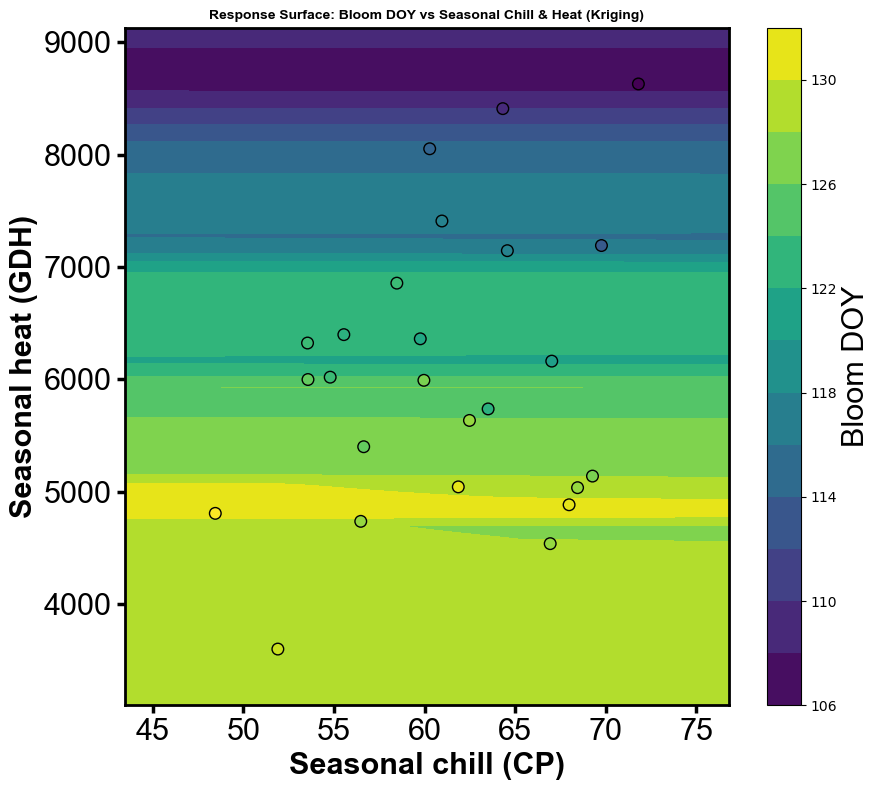

In [58]:
# =========================================================
# BLOCK XX – Kriging response surface (similar to Figs. 4 & 5)
# Bloom DOY as function of seasonal Chill_total_CP & Heat_total_GDH
# =========================================================

   # Kriging interpolation

# --- 1. Paths ---

req_path   = os.path.join(outputs_dir, "Seasonal_Chill_Heat_Requirements.csv")
bloom_path = os.path.join(outputs_dir, "y_bloom.csv")

# --- 2. Load seasonal totals + bloom DOY ---
req   = pd.read_csv(req_path)
bloom = pd.read_csv(bloom_path)

df = pd.merge(req, bloom, on="BloomYear", how="inner")
df = df.dropna(subset=["Chill_total_CP", "Heat_total_GDH", "Bloom_DOY"])

df = df.rename(columns={
    "Chill_total_CP": "CP",
    "Heat_total_GDH": "GDH",
    "Bloom_DOY":      "BloomDOY"
})

# --- 3. Prepare Kriging inputs ---
x = df["CP"].values
y = df["GDH"].values
z = df["BloomDOY"].values

# --- 4. Fit Ordinary Kriging model ---
OK = OrdinaryKriging(
    x, y, z,
    variogram_model="spherical",
    verbose=False,
    enable_plotting=False
)

# --- 5. Build CP–GDH grid ---
cp_grid  = np.linspace(x.min() - 5,    x.max() + 5,    50)
gdh_grid = np.linspace(y.min() - 500,  y.max() + 500, 50)

zz, ss = OK.execute("grid", cp_grid, gdh_grid)
CP_mesh, GDH_mesh = np.meshgrid(cp_grid, gdh_grid)

# --- 6. Plot response surface ---
plt.figure(figsize=(9, 8))

cont = plt.contourf(CP_mesh, GDH_mesh, zz, levels=15, cmap="viridis")
cbar = plt.colorbar(cont)
cbar.set_label("Bloom DOY", fontsize=font_dict["y_label"]["fontsize"],
               fontfamily=font_dict["y_label"]["fontfamily"])

# Original year points
plt.scatter(
    x, y, c=z,
    cmap="viridis",
    edgecolor="k", s=70
)

plt.xlabel("Seasonal chill (CP)", **font_dict["x_label"])
plt.ylabel("Seasonal heat (GDH)", **font_dict["y_label"])
plt.title("Response Surface: Bloom DOY vs Seasonal Chill & Heat (Kriging)",
          **font_dict["title"])

# Apply tick label fonts
plt.xticks(
    fontsize=font_dict["tick_labels"]["labelsize"],
    fontfamily=font_dict["tick_labels"]["fontfamily"]
)
plt.yticks(
    fontsize=font_dict["tick_labels"]["labelsize"],
    fontfamily=font_dict["tick_labels"]["fontfamily"]
)

# Thicker ticks + spines
plt.tick_params(axis="both", width=2.5, length=6)
for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

plt.tight_layout()
plt.show()

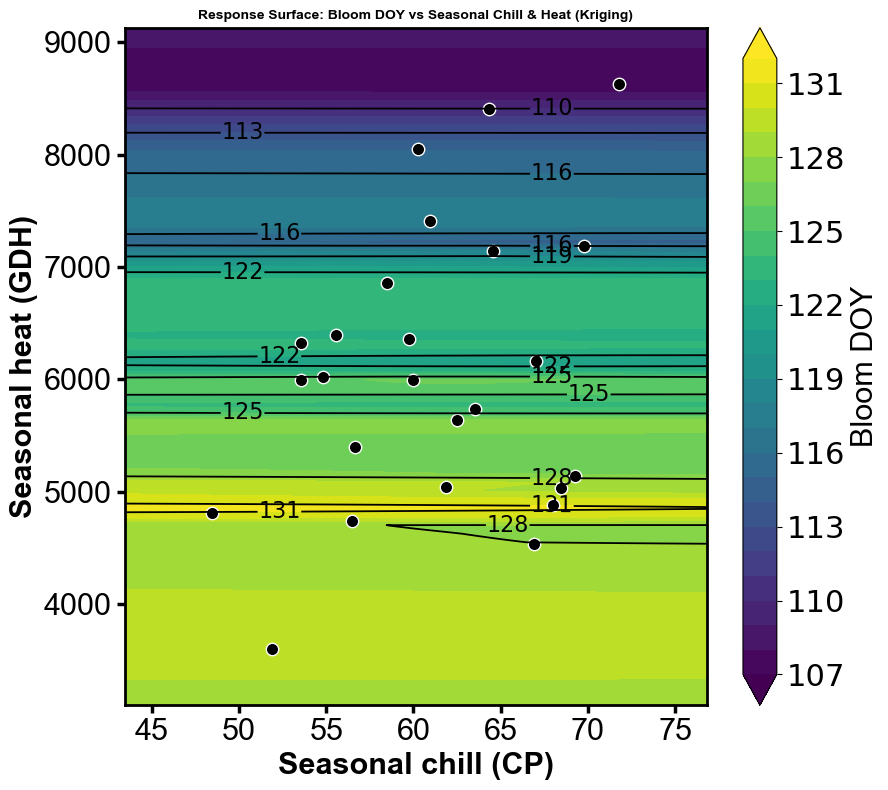

In [59]:
# =========================================================
# BLOCK XX – Kriging response surface (similar to Figs. 4 & 5)
# Bloom DOY as function of seasonal Chill_total_CP & Heat_total_GDH
# =========================================================

   # Kriging interpolation

# ==========================================================
# 1. Load & prepare data
# ==========================================================

req_path   = os.path.join(outputs_dir, "Seasonal_Chill_Heat_Requirements.csv")
bloom_path = os.path.join(outputs_dir, "y_bloom.csv")

req   = pd.read_csv(req_path)
bloom = pd.read_csv(bloom_path)

df = pd.merge(req, bloom, on="BloomYear", how="inner")
df = df.dropna(subset=["Chill_total_CP", "Heat_total_GDH", "Bloom_DOY"])

df = df.rename(columns={
    "Chill_total_CP": "CP",
    "Heat_total_GDH": "GDH",
    "Bloom_DOY":      "BloomDOY"
})

# --- Prepare Kriging inputs ---
x = df["CP"].values
y = df["GDH"].values
z = df["BloomDOY"].values

# ==========================================================
# 2. Fit Kriging model
# ==========================================================
OK = OrdinaryKriging(
    x, y, z,
    variogram_model="spherical",
    verbose=False,
    enable_plotting=False
)

cp_min, cp_max   = x.min(), x.max()
gdh_min, gdh_max = y.min(), y.max()

# --- Build CP–GDH grid ---
cp_grid  = np.linspace(cp_min  - 5,   cp_max  + 5,   80)
gdh_grid = np.linspace(gdh_min - 500, gdh_max + 500, 80)

zz, ss = OK.execute("grid", cp_grid, gdh_grid)
zz = np.array(zz)

CP_mesh, GDH_mesh = np.meshgrid(cp_grid, gdh_grid)

# ==========================================================
# 3. Contour levels
# ==========================================================
bmin = int(np.floor(z.min()))
bmax = int(np.ceil(z.max()))

levels_all = np.arange(bmin, bmax + 1, 1)    # color levels
line_levels = levels_all[::3]                # contour lines every 3 DOY

# ==========================================================
# 4. PLOT — POSTER FORMAT
# ==========================================================
fig, ax = plt.subplots(figsize=(9, 8))

# Filled response surface
cf = ax.contourf(
    CP_mesh, GDH_mesh, zz,
    levels=levels_all,
    cmap="viridis",
    extend="both"
)

# Contour lines
cs = ax.contour(
    CP_mesh, GDH_mesh, zz,
    levels=line_levels,
    colors="black",
    linewidths=1.3
)

# Contour labels
ax.clabel(
    cs,
    inline=True,
    fontsize=font_dict["tick_labels"]["labelsize"] - 6,
    fmt="%d"
)

# Plot original years
ax.scatter(
    x, y,
    c="black",
    s=80,
    edgecolor="white",
    linewidths=1.0
)

# Colorbar formatting
cbar = fig.colorbar(cf, ax=ax)
cbar.set_label("Bloom DOY",
               fontsize=font_dict["y_label"]["fontsize"],
               fontfamily=font_dict["y_label"]["fontfamily"])
cbar.ax.tick_params(labelsize=font_dict["tick_labels"]["labelsize"])

# Axis labels + title
ax.set_xlabel("Seasonal chill (CP)", **font_dict["x_label"])
ax.set_ylabel("Seasonal heat (GDH)", **font_dict["y_label"])
ax.set_title("Response Surface: Bloom DOY vs Seasonal Chill & Heat (Kriging)",
             **font_dict["title"])

# Tick styling
ax.tick_params(axis="both", width=2.5, length=6)
plt.xticks(fontsize=font_dict["tick_labels"]["labelsize"],
           fontfamily=font_dict["tick_labels"]["fontfamily"])
plt.yticks(fontsize=font_dict["tick_labels"]["labelsize"],
           fontfamily=font_dict["tick_labels"]["fontfamily"])

# Thicker axis spines
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.tight_layout()
plt.show()

In [60]:
df_dates = pd.read_csv(f"{outputs_dir}\y_bloom.csv")
df_sums = pd.read_csv(f"{outputs_dir}\Seasonal_Chill_Heat_Requirements.csv")


df_merged = pd.merge(
    df_dates,
    df_sums,
    left_on="BloomYear",
    right_on="BloomYear",
    how="inner"   # inner keeps only common years
)
df_merged.head(3)

,BloomYear,Bloom_DOY,Chill_total_CP,Heat_total_GDH
0,1997,128,66.936298,4538.645833
1,1998,114,69.766270,7191.801170
2,1999,128,68.447117,5036.818817


In [61]:
x = df_merged['Chill_total_CP']
y = df_merged['Heat_total_GDH']
z = df_merged['Bloom_DOY']

In [62]:
# data points
x = df_merged["Chill_total_CP"].values
y = df_merged["Heat_total_GDH"].values

points = np.column_stack((x, y))
hull = ConvexHull(points)

# create a Path object from hull vertices
hull_path = Path(points[hull.vertices])

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(xi, yi)
grid_points = np.column_stack((X.flatten(), Y.flatten()))

OK = OrdinaryKriging(
    x, y, df_merged["Bloom_DOY"].values,
    variogram_model="spherical",
    enable_plotting=False,
    verbose=False,
)

Z, _ = OK.execute("grid", xi, yi)

# reshape
Z = np.array(Z)

# mask values outside hull
inside = hull_path.contains_points(grid_points)
inside_mask = inside.reshape(X.shape)

Z_masked = np.where(inside_mask, Z, np.nan)   # outside hull → NaN

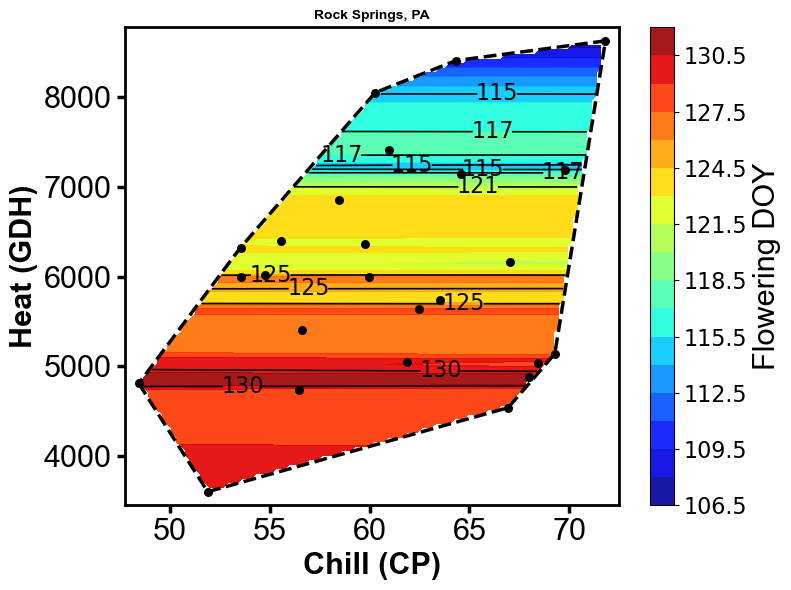

In [66]:
plt.figure(figsize=(8, 6))

# === Filled surface inside convex hull ===
cf = plt.contourf(
    X, Y, Z_masked,
    levels=20,
    cmap="jet",
    alpha=0.90
)

# === Contour lines ===
cs = plt.contour(
    X, Y, Z_masked,
    # levels=2,               # number of contour lines
    levels=[115,117,121, 125, 130],   # Wenatchee
    # levels=[128, 131 ,136, 144],  #Geneva

    colors="black",
    linewidths=1.2
)

# Contour labels (bigger for poster readability)
plt.clabel(
    cs,
    inline=True,
    fontsize=font_dict["tick_labels"]["labelsize"] - 6,
    fmt="%d"
)

# === Observed points ===
plt.scatter(
    x, y,
    # c=df_merged["Bloom_DOY"],
    # cmap="viridis",
    color="black",
    edgecolor="k",
    s=30
)

# === Convex hull boundary ===
hull_pts = points[hull.vertices]
hull_pts = np.vstack([hull_pts, hull_pts[0]])  # add first point at end to close

plt.plot(
    hull_pts[:, 0],
    hull_pts[:, 1],
    "k--",
    lw=2.5

)

# === Colorbar with poster font ===
cbar = plt.colorbar(cf)
cbar.set_label(
    "Flowering DOY",
    fontsize=font_dict["y_label"]["fontsize"],
    fontfamily=font_dict["y_label"]["fontfamily"]
)
cbar.ax.tick_params(labelsize=font_dict["tick_labels"]["labelsize"]-6)

# === Axes labels and title ===
plt.xlabel("Chill (CP)", **font_dict["x_label"])
plt.ylabel("Heat (GDH)", **font_dict["y_label"])
plt.title(f"{location}", **font_dict["title"])

# === Tick formatting ===
plt.xticks(
    fontsize=font_dict["tick_labels"]["labelsize"],
    fontfamily=font_dict["tick_labels"]["fontfamily"]
)
plt.yticks(
    fontsize=font_dict["tick_labels"]["labelsize"],
    fontfamily=font_dict["tick_labels"]["fontfamily"]
)

# === Thicker ticks + spines ===
plt.tick_params(axis="both", width=2.5, length=6, direction="out")
for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

# Add margins to avoid data touching the axis boundaries
ax = plt.gca()

dx = ax.get_xlim()[1] - ax.get_xlim()[0]
dy = ax.get_ylim()[1] - ax.get_ylim()[0]

ax.set_xlim(ax.get_xlim()[0] - 0.03*dx,
            ax.get_xlim()[1] + 0.03*dx)

ax.set_ylim(ax.get_ylim()[0] - 0.03*dy,
            ax.get_ylim()[1] + 0.03*dy)


plt.tight_layout()
# plt.savefig("wenatchee.png", dpi=300)
plt.savefig("Pictures/Kriging Surface Masked for Wenatchee.jpg", 
            dpi=300, bbox_inches="tight")
plt.show()